# E-Commerce


## FRM Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations
from datetime import datetime
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import r2_score, mean_squared_error

In [2]:
pd.options.mode.chained_assignment = None

plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = 1

### 1. General Infos & Playing with Features

In [3]:
df = pd.read_csv('data.csv',
                 encoding="ISO-8859-1")

df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

- Note: when read csv file, it happened to the error: 'utf-8' codec can't decode byte 0xa3 in position... we can add a parameter to solve the problem: **encoding="ISO-8859-1"**

In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- From the above information, we can check and find out some missing values in columns named `Description`and `CustomerID`.

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

> Let's drop missing values.

In [7]:
df = df[df['Description'].notnull()]

In [8]:
df[df['CustomerID'].isnull()]

InvoiceNo StockCode                      Description  Quantity  \
1443      536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444      536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   
1445      536544     21786               POLKADOT RAIN HAT          4   
1446      536544     21787            RAIN PONCHO RETROSPOT         2   
1447      536544     21790               VINTAGE SNAP CARDS         9   
...          ...       ...                              ...       ...   
541536    581498    85099B          JUMBO BAG RED RETROSPOT         5   
541537    581498    85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   
541538    581498     85150    LADIES & GENTLEMEN METAL SIGN         1   
541539    581498     85174                S/4 CACTI CANDLES         1   
541540    581498       DOT                   DOTCOM POSTAGE         1   

            InvoiceDate  UnitPrice  CustomerID         Country  
1443    12/1/2010 14:32       2.51         NaN  United Kingdom  
1444    12/1/2010 14:32       2.51         NaN  United Kingdom  
1445    12/1/2010 14:32       0.85         NaN  United Kingdom  
1446    12/1/2010 14:32       1.66         NaN  United Kingdom  
1447    12/1/2010 14:32       1.66         NaN  United Kingdom  
...                 ...        ...         ...             ...  
541536  12/9/2011 10:26       4.13         NaN  United Kingdom  
541537  12/9/2011 10:26       4.13         NaN  United Kingdom  
541538  12/9/2011 10:26       4.96         NaN  United Kingdom  
541539  12/9/2011 10:26      10.79         NaN  United Kingdom  
541540  12/9/2011 10:26    1714.17         NaN  United Kingdom  

[133626 rows x 8 columns]

- StockCode contains non-numeric records i.e. `DOT`. It is a cue for examining stock codes.

In [9]:
print('We have {} observations.'.format(df.shape[0]))


df = df[df['CustomerID'].notnull()]


print('We have {} observations after removing unknown customers.'.format(df.shape[0]))

We have 540455 observations.
We have 406829 observations after removing unknown customers.


> Let's check the whole data set again.

In [10]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

> Let's deal with missing values deeper.

In [11]:
df[df['Description'].str.len()<5]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []

### InvoiceNo

In [12]:
df['InvoiceNo'].value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
554155      1
570248      1
545414      1
545418      1
565192      1
Name: InvoiceNo, Length: 22190, dtype: int64

- InvoiceNo has coded with 6 digit numeric characters. We can see that some InvoiceNo records starts with the letter **C. This means cancellation.**


- Let's find them out.

In [13]:
# pick out cancellation orders
df[df['InvoiceNo'].str[0] == 'C']

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

            InvoiceDate  UnitPrice  CustomerID         Country  
141      12/1/2010 9:41      27.50     14527.0  United Kingdom  
154      12/1/2010 9:49       4.65     15311.0  United Kingdom  
235     12/1/2010 10:24       1.65     17548.0  United Kingdom  
236     12/1/2010 10:24       0.29     17548.0  United Kingdom  
237     12/1/2010 10:24       0.29     17548.0  United Kingdom  
...                 ...        ...         ...             ...  
540449   12/9/2011 9:57       0.83     14397.0  United Kingdom  
541541  12/9/2011 10:28     224.69     15498.0  United Kingdom  
541715  12/9/2011 11:57      10.95     15311.0  United Kingdom  
541716  12/9/2011 11:58       1.25     17315.0  United Kingdom  
541717  12/9/2011 11:58       1.25     17315.0  United Kingdom  

[8905 rows x 8 columns]

- We find that cancelled invoices have negative quantity.


- Let's add a new column to distinguish them using 0 and 1.

In [14]:
df['Cancelled_invoices'] = df['InvoiceNo'].apply(lambda x: 1 if x[0]=='C' else 0)

In [15]:
cancelled_invoiceNo = df[df['Cancelled_invoices'] == 1]['InvoiceNo'].tolist()

cancelled_invoiceNo = [x[1:] for x in cancelled_invoiceNo]

cancelled_invoiceNo[:5]

['536379', '536383', '536391', '536391', '536391']

In [16]:
# We also can check the different pattern about InvoiceNo in this method.

df[df['InvoiceNo'].str.len() != 6]

InvoiceNo StockCode                       Description  Quantity  \
141      C536379         D                          Discount        -1   
154      C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235      C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236      C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237      C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...          ...       ...                               ...       ...   
540449   C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541   C581499         M                            Manual        -1   
541715   C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
541716   C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717   C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

            InvoiceDate  UnitPrice  CustomerID         Country  \
141      12/1/2010 9:41      27.50     14527.0  United Kingdom   
154      12/1/2010 9:49       4.65     15311.0  United Kingdom   
235     12/1/2010 10:24       1.65     17548.0  United Kingdom   
236     12/1/2010 10:24       0.29     17548.0  United Kingdom   
237     12/1/2010 10:24       0.29     17548.0  United Kingdom   
...                 ...        ...         ...             ...   
540449   12/9/2011 9:57       0.83     14397.0  United Kingdom   
541541  12/9/2011 10:28     224.69     15498.0  United Kingdom   
541715  12/9/2011 11:57      10.95     15311.0  United Kingdom   
541716  12/9/2011 11:58       1.25     17315.0  United Kingdom   
541717  12/9/2011 11:58       1.25     17315.0  United Kingdom   

        Cancelled_invoices  
141                      1  
154                      1  
235                      1  
236                      1  
237                      1  
...                    ...  
540449                   1  
541541                   1  
541715                   1  
541716                   1  
541717                   1  

[8905 rows x 9 columns]

In [17]:
df = df[df['Cancelled_invoices'] == 0]

### StockCode

- Actually, Stock Codes generally contains 5 digit numerical codes.

In [18]:
df[df['StockCode'].str.contains('^[a-zA-Z]')]['StockCode'].value_counts()

POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

In [19]:
df[df['StockCode'].str.contains('^[a-zA-Z]')]['Description'].value_counts()

POSTAGE                       1099
Manual                         290
CARRIAGE                       133
DOTCOM POSTAGE                  16
Bank Charges                    12
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64

- It looks like data contains more than customer transactions. Let's drop them.

In [20]:
df[df['StockCode'].str.len() > 5]['StockCode'].value_counts()

85123A    2035
85099B    1618
82494L     820
85099F     664
85099C     659
          ... 
35610C       1
90187B       1
90190A       1
90190B       1
90214Z       1
Name: StockCode, Length: 875, dtype: int64

In [21]:
df[df['StockCode'].str.len() > 5]['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2028
JUMBO BAG RED RETROSPOT                1618
WOODEN FRAME ANTIQUE WHITE              820
JUMBO BAG STRAWBERRY                    664
JUMBO  BAG BAROQUE BLACK WHITE          659
                                       ... 
PURPLE/BLUE CERAMIC CANDLE HOLDER         1
ORANGE PENDANT TRIPLE SHELL NECKLAC       1
ROSE PENDANT TRIPLE SHELL NECKLACE        1
BLACK CHRISTMAS FLOCK DROPLET             1
CURIOUS IMAGES SCRAP BOOK SET             1
Name: Description, Length: 887, dtype: int64

- We find that some stock codes have a letter at the end of their codes. I don't know what they refers, so I will keep them.

In [22]:
df = df[~ df['StockCode'].str.contains('^[a-zA-Z]')]

In [23]:
df['Description'] = df['Description'].str.lower()

 Stock Codes - Description

In [24]:
df.groupby('StockCode')['Description'].nunique()[df.groupby('StockCode')['Description'].nunique() != 1]

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
         ..
85184C    2
85185B    2
90014A    2
90014B    2
90014C    2
Name: Description, Length: 213, dtype: int64

- 213 Stock codes have more than one description. Let's check some of them.

In [25]:
df[df['StockCode'] == '17107D']['Description'].value_counts()

flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: Description, dtype: int64

In [26]:
df[df['StockCode'] == '85185B']['Description'].value_counts()

pink horse sock puppet        50
pink horse sock puppet kit    18
Name: Description, dtype: int64

### CustomerID

In [27]:
df.CustomerID.value_counts()

17841.0    7838
14911.0    5591
14096.0    5095
12748.0    4580
14606.0    2697
           ... 
14705.0       1
13841.0       1
17715.0       1
18084.0       1
13099.0       1
Name: CustomerID, Length: 4335, dtype: int64

In [28]:
# Top 15 customers
customer_counts_15 = df['CustomerID'].value_counts().sort_values(ascending=False).head(15)

customer_counts_15

17841.0    7838
14911.0    5591
14096.0    5095
12748.0    4580
14606.0    2697
15311.0    2379
14646.0    2064
13089.0    1818
13263.0    1672
14298.0    1637
15039.0    1502
14156.0    1387
18118.0    1278
14159.0    1203
14796.0    1140
Name: CustomerID, dtype: int64

Text(0.5, 0, 'Transaction Count')

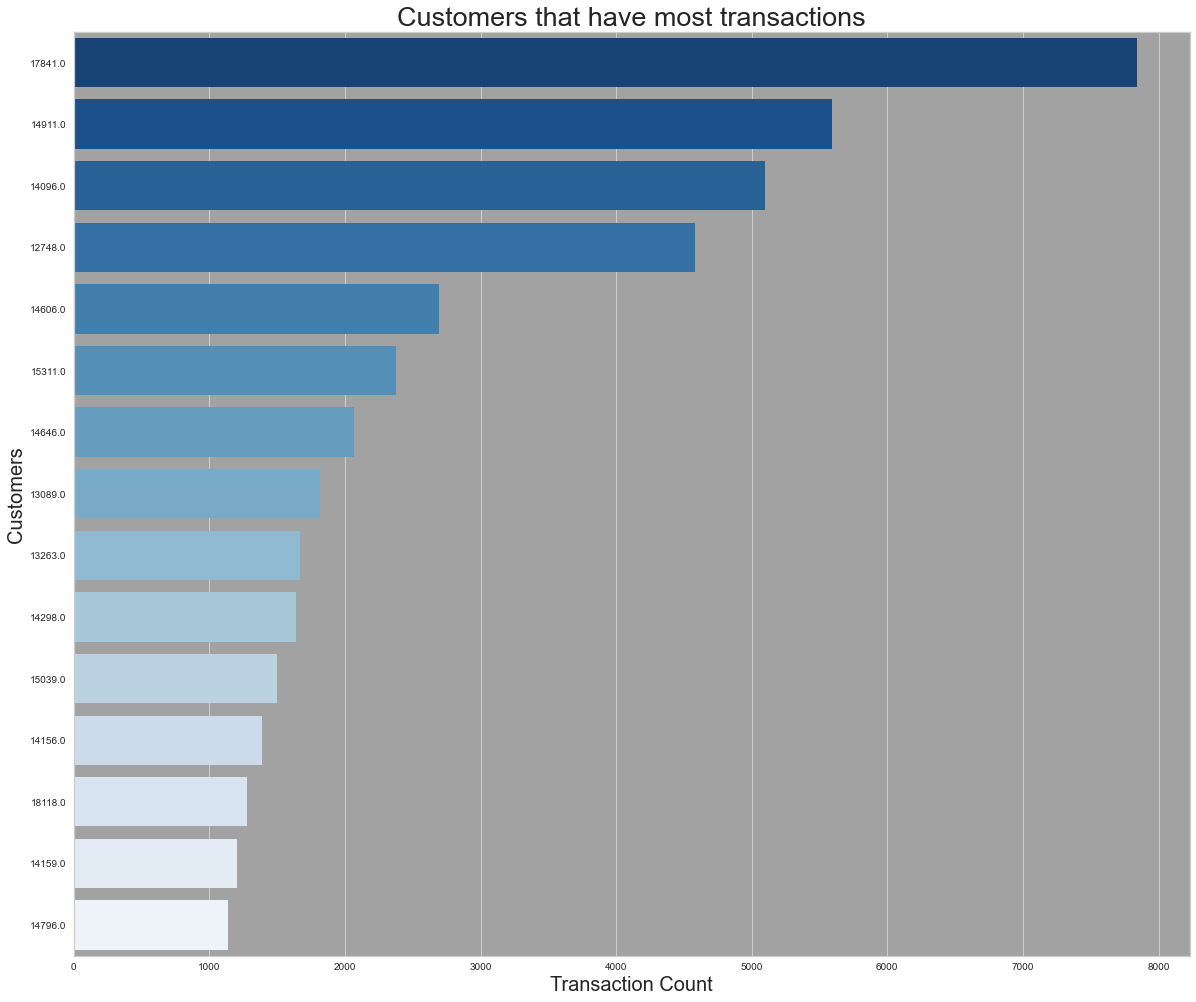

In [29]:
# visualization

plt.figure(figsize=(20,17))

sns.barplot(x=customer_counts_15.values,
            y=customer_counts_15.index,
            order=customer_counts_15.index,
            orient='h',
            palette='Blues_r')

plt.title("Customers that have most transactions", fontsize=27)
plt.ylabel("Customers", fontsize=20)
plt.xlabel("Transaction Count", fontsize=20)

### Country

In [30]:
df['Country'].value_counts()

United Kingdom          354005
Germany                   8659
France                    8034
EIRE                      7138
Spain                     2423
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1425
Australia                 1184
Norway                    1049
Channel Islands            744
Italy                      741
Finland                    647
Cyprus                     612
Sweden                     428
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     248
Unspecified                244
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

In [31]:
Country_top_25 = df['Country'].value_counts().sort_values(ascending=False).head(25)
Country_top_25

United Kingdom     354005
Germany              8659
France               8034
EIRE                 7138
Spain                2423
Netherlands          2326
Belgium              1935
Switzerland          1811
Portugal             1425
Australia            1184
Norway               1049
Channel Islands       744
Italy                 741
Finland               647
Cyprus                612
Sweden                428
Austria               384
Denmark               367
Poland                325
Japan                 321
Israel                248
Unspecified           244
Singapore             215
Iceland               182
USA                   179
Name: Country, dtype: int64

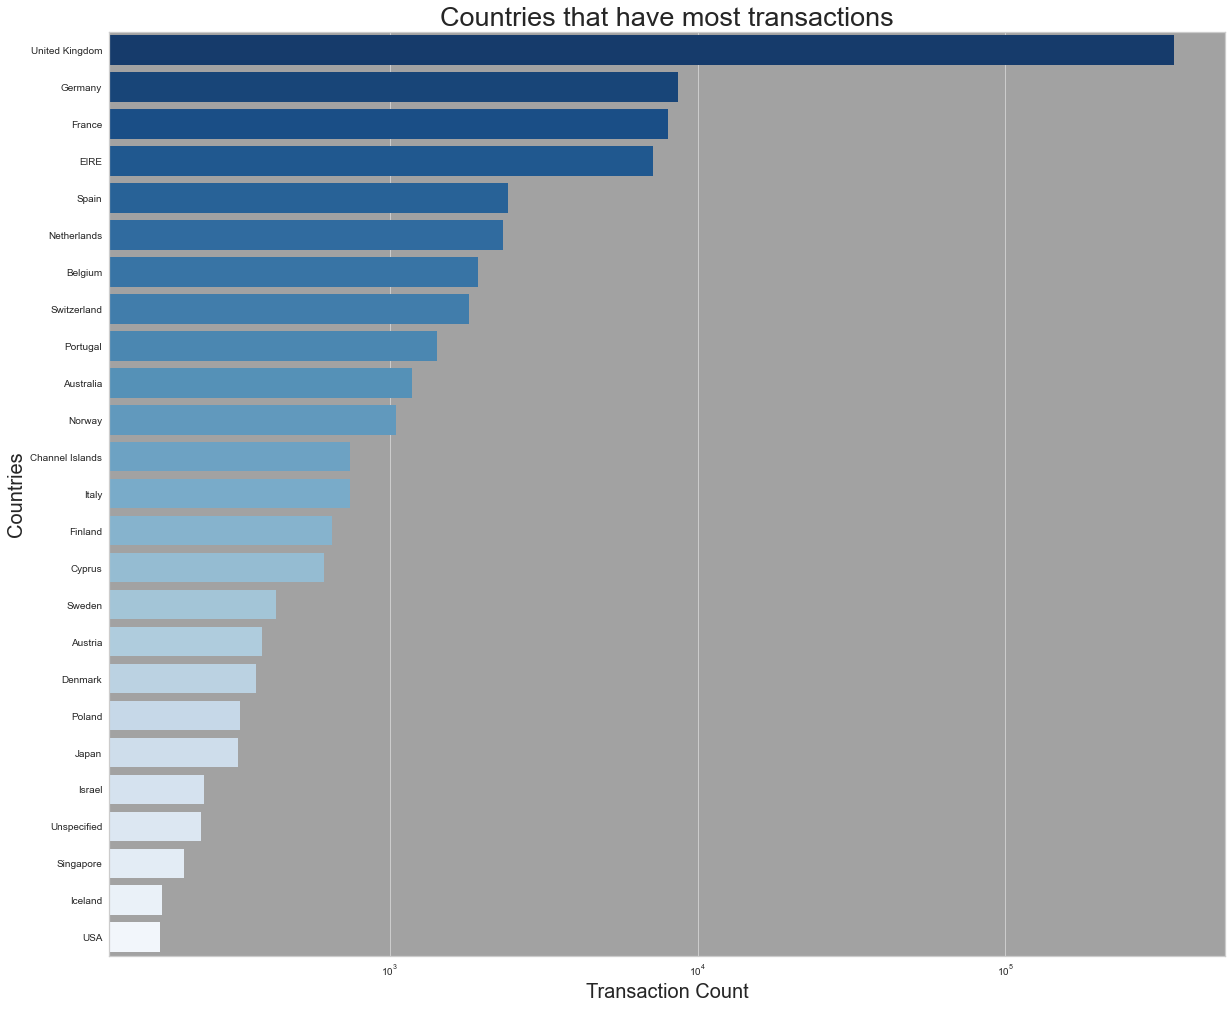

In [32]:
plt.figure(figsize=(20,17))

sns.barplot(x=Country_top_25.values,
            y=Country_top_25.index,
            order=Country_top_25.index,
            orient='h',
            palette='Blues_r')

plt.title("Countries that have most transactions", fontsize=27)
plt.ylabel("Countries", fontsize=20)
plt.xlabel("Transaction Count", fontsize=20)
plt.xscale("log")

### UnitPrice

In [33]:
df['UnitPrice'].describe()

count    396370.000000
mean          2.867983
std           4.264566
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

- There is a problem.The minimum unit price is 0. Does this make sense？



- Let's find out those including 0 unit prices.And we have to remove them.

In [34]:
df[df['UnitPrice'] == 0]

InvoiceNo StockCode                          Description  Quantity  \
9302      537197     22841         round cake tin vintage green         1   
33576     539263     22580         advent calendar gingham sack         4   
40089     539722     22423             regency cakestand 3 tier        10   
47068     540372     22090              paper bunting retrospot        24   
47070     540372     22553               plasters in tin skulls        24   
56674     541109     22168        organiser wood antique white          1   
86789     543599    84535B         fairy cakes notebook a6 size        16   
130188    547417     22062  ceramic bowl with love heart design        36   
139453    548318     22055   mini cake stand  hanging strawbery         5   
145208    548871     22162          heart garland rustic padded         2   
157042    550188     22636   childs breakfast set circus parade         1   
187613    553000     47566                        party bunting         4   
198383    554037     22619            set of 6 soldier skittles        80   
279324    561284     22167           oval wall mirror diamante          1   
282912    561669     22960             jam making set with jars        11   
298054    562973     23157           set of 6 nativity magnets        240   
314745    564651     23270     set of 2 ceramic painted hearts         96   
314746    564651     23268  set of 2 ceramic christmas reindeer       192   
314747    564651     22955             36 foil star cake cases        144   
314748    564651     21786                   polkadot rain hat        144   
379913    569716     22778                   glass cloche small         2   
420404    572893     21208          pastel colour honeycomb fan         5   
436428    574138     23234        biscuit tin vintage christmas       216   
436597    574175     22065       christmas pudding trinket pot         12   
439361    574469     22385            jumbo bag spaceboy design        12   
446125    574879     22625                   red kitchen scales         2   
446793    574920     22899         children's apron dolly girl          1   
446794    574920     23480       mini lights woodland mushrooms         1   
454463    575579     22437        set of 9 black skull balloons        20   
454464    575579     22089        paper bunting vintage paisley        24   
479079    577129     22464          hanging metal heart lantern         4   
480649    577314     23407       set of 2 trays home sweet home         2   
502122    578841     84826       asstd design 3d paper stickers     12540   

             InvoiceDate  UnitPrice  CustomerID         Country  \
9302     12/5/2010 14:02        0.0     12647.0         Germany   
33576   12/16/2010 14:36        0.0     16560.0  United Kingdom   
40089   12/21/2010 13:45        0.0     14911.0            EIRE   
47068     1/6/2011 16:41        0.0     13081.0  United Kingdom   
47070     1/6/2011 16:41        0.0     13081.0  United Kingdom   
56674    1/13/2011 15:10        0.0     15107.0  United Kingdom   
86789    2/10/2011 13:08        0.0     17560.0  United Kingdom   
130188   3/23/2011 10:25        0.0     13239.0  United Kingdom   
139453   3/30/2011 12:45        0.0     13113.0  United Kingdom   
145208    4/4/2011 14:42        0.0     14410.0  United Kingdom   
157042   4/14/2011 18:57        0.0     12457.0     Switzerland   
187613   5/12/2011 15:21        0.0     17667.0  United Kingdom   
198383   5/20/2011 14:13        0.0     12415.0       Australia   
279324   7/26/2011 12:24        0.0     16818.0  United Kingdom   
282912   7/28/2011 17:09        0.0     12507.0           Spain   
298054   8/11/2011 11:42        0.0     14911.0            EIRE   
314745   8/26/2011 14:19        0.0     14646.0     Netherlands   
314746   8/26/2011 14:19        0.0     14646.0     Netherlands   
314747   8/26/2011 14:19        0.0     14646.0     Netherlands   
314748   8/26/2011 14:19        0.0     14646.0 

In [35]:
df = df[df['UnitPrice'] > 0]

print("We have {} observations after removing records that have 0 unit price.".format(df.shape[0]))

We have 396337 observations after removing records that have 0 unit price.


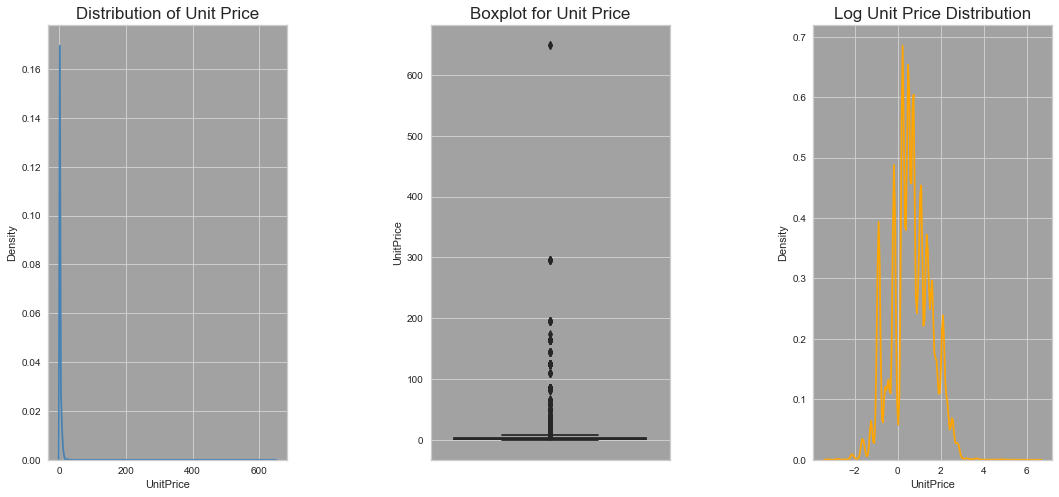

In [36]:
# visualization

fig, axes = plt.subplots(1, 3, figsize=(18,8))

plt.subplots_adjust(wspace=0.6)

sns.kdeplot(df['UnitPrice'],
            ax=axes[0],
            color='steelblue').set_title('Distribution of Unit Price', fontsize=17)

sns.boxplot(y=df['UnitPrice'],
            ax=axes[1],
            color='purple').set_title('Boxplot for Unit Price',fontsize=17)

sns.kdeplot(np.log(df['UnitPrice']),
            ax=axes[2],
            color='orange').set_title('Log Unit Price Distribution',fontsize=17)

plt.show()

In [37]:
print("Lower limit for UnitPrice: " + str(np.exp(-2)))
print("Upper limit for UnitPrice: " + str(np.exp(3)))

Lower limit for UnitPrice: 0.1353352832366127
Upper limit for UnitPrice: 20.085536923187668


In [38]:
np.quantile(df['UnitPrice'], 0.99)

12.75

In [39]:
df = df[(df['UnitPrice'] > 0.1)&(df['UnitPrice'] < 20)]

print("We have {} observations after removing unit prices smaller than 20 and greater than 0.1.".format(df.shape[0]))

We have 395385 observations after removing unit prices smaller than 20 and greater than 0.1.


> Let's visualize the adjusted Unit price.

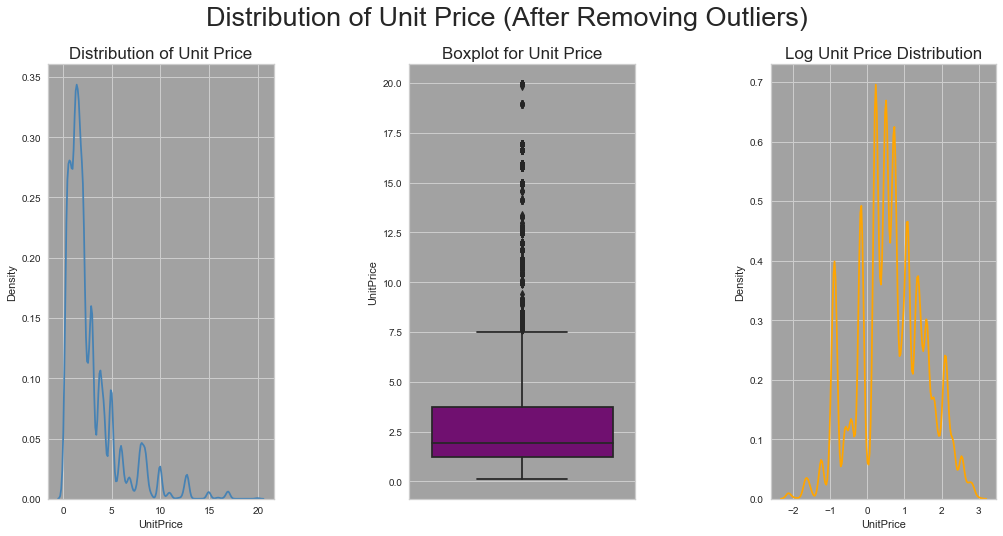

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(17,8))

plt.subplots_adjust(wspace=0.6)

sns.kdeplot(df['UnitPrice'],
            ax=axes[0],
            color='steelblue').set_title('Distribution of Unit Price',fontsize=17)

sns.boxplot(y=df['UnitPrice'],
            ax=axes[1],
            color='purple').set_title('Boxplot for Unit Price',fontsize=17)

sns.kdeplot(np.log(df['UnitPrice']),
            ax=axes[2],
            color='orange').set_title('Log Unit Price Distribution',fontsize=17)

fig.suptitle('Distribution of Unit Price (After Removing Outliers)', fontsize=27)

plt.show()

### Quantity

In [41]:
df['Quantity'].describe()

count    395385.000000
mean         12.946075
std         179.665683
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

- We can see 75% is 12, but the maximum reaches 80995. Let's look at these outliers.

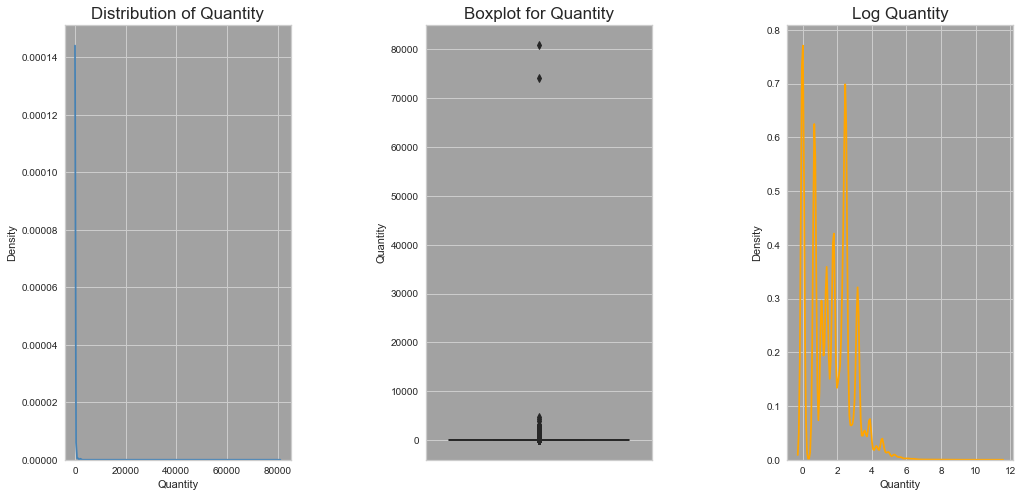

In [42]:
fig, axes = plt.subplots(1,3, figsize=(17,8))
plt.subplots_adjust(wspace=0.6)

sns.kdeplot(df['Quantity'],
            ax=axes[0],
            color='steelblue').set_title('Distribution of Quantity',fontsize=17)

sns.boxplot(y=df['Quantity'],
            ax=axes[1],
            color='purple').set_title('Boxplot for Quantity',fontsize=17)

sns.kdeplot(np.log(df['Quantity']),
            ax=axes[2],
            color='orange').set_title('Log Quantity',fontsize=17)

plt.show()

In [43]:
print('Upper limit for Quantity: '+ str(np.exp(5)))

Upper limit for Quantity: 148.4131591025766


In [44]:
np.quantile(df['Quantity'], 0.99)

120.0

In [45]:
# let's adjust Quantity and then visualize it.

df = df[df['Quantity'] < 150]

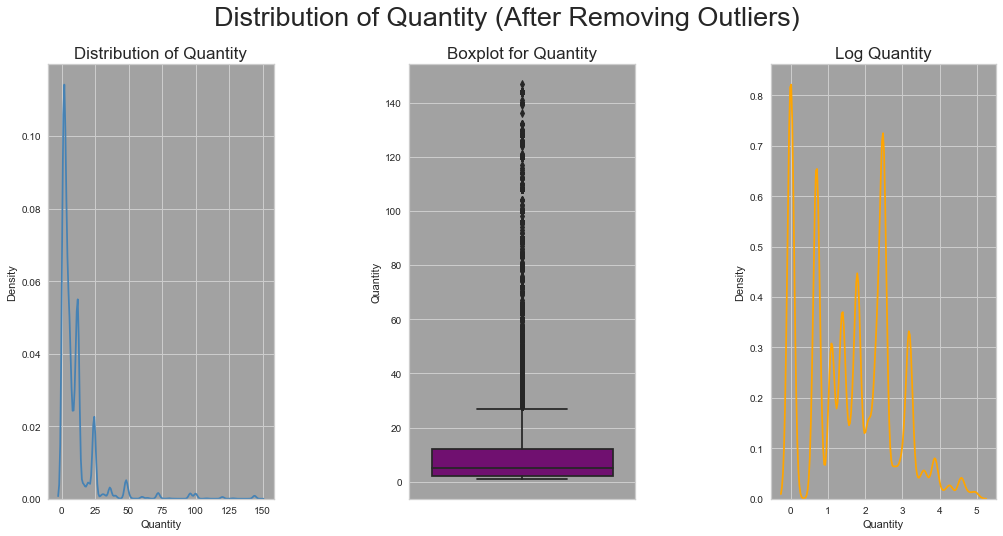

In [46]:
fig, axes = plt.subplots(1,3, figsize=(17,8))
plt.subplots_adjust(wspace=0.6)

sns.kdeplot(df['Quantity'],
            ax=axes[0],
            color='steelblue').set_title('Distribution of Quantity',fontsize=17)

sns.boxplot(y=df['Quantity'],
            ax=axes[1],
            color='purple').set_title('Boxplot for Quantity',fontsize=17)

sns.kdeplot(np.log(df['Quantity']),
            ax=axes[2],
            color='orange').set_title('Log Quantity',fontsize=17)

fig.suptitle('Distribution of Quantity (After Removing Outliers)',fontsize=27)
plt.show()

- Let's do some additional changes about our data.

In [47]:
df['Total_Price'] = df['Quantity'] * df['UnitPrice']


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [48]:
df.drop(columns='Cancelled_invoices',
        inplace=True)

df.to_csv('Online_Retail_data.csv',
          index=True)

## 2. Cohort Analysis


> A cohort simply means that a group of people they have same characteristics.

- Generally, we have three type of cohort analysis:

    - Time cohorts or Acquisition cohorts: Groups are divided by first activity.

    - Behavior cohorts or Segment-Based cohorts: Groups are divided by their behaivors and actions about your service.

    - Size cohorts: Size-based cohorts refer to the various sizes of customers who purchase a company's products or services.
    
    


> Cohort analysis is a subset of behavioral analytics that takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span.


> Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time or is only appearing to improve because of growth.



> Cohort analysis proves to be valuable because it helps to separate growth metrics from engagement metrics as growth can easily mask engagement problems. In reality, the lack of activity of the old users is being hidden by the impressive growth numbers of new users, which results in concealing the lack of engagement from a small number of people.



> Cohort analysis is a better way of looking at data. Its application is not limited to a single industry or function. For example, eCommerce companies can use cohort analysis to spot products that have more potential for sales growth. In digital marketing, it can help identify web pages that perform well based on time spent on websites, conversions or sign-ups. In product marketing, this analysis can be used to identify the success of feature adoption rate and also to reduce churn rates.

In [49]:
print('Min date: {}\nMax date: {}'.format(df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Min date: 2010-12-01 08:26:00
Max date: 2011-12-09 12:50:00


In [50]:
print('Time difference is: {}'.format(df['InvoiceDate'].max() - df['InvoiceDate'].min()))

Time difference is: 373 days 04:24:00


- We find that the dataset contains invoice records for more than one year. Let's apply cohort analysis. We can create monthly cohorts.


- We will group customers for first invoice record. Cohort index will be number of months since first transaction.

In [51]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [52]:
def get_dates(df, col):
    
    year = df[col].dt.year
    
    month = df[col].dt.month
    
    day = df[col].dt.day
    
    return year, month, day

In [53]:
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   white hanging heart t-light holder         6   
1    536365     71053                  white metal lantern         6   
2    536365    84406B       cream cupid hearts coat hanger         8   
3    536365    84029G  knitted union flag hot water bottle         6   
4    536365    84029E       red woolly hottie white heart.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_Price  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34   

  InvoiceMonth CohortMonth  
0   2010-12-01  2010-12-01  
1   2010-12-01  2010-12-01  
2   2010-12-01  2010-12-01  
3   2010-12-01  2010-12-01  
4   2010-12-01  2010-12-01

In [54]:
invoice_year, invoice_month, invoice_day = get_dates(df, 'InvoiceMonth')

cohort_year, cohort_month, cohort_day = get_dates(df, 'CohortMonth')

In [55]:
# calculate the difference between invoices' and cohorts'.

year_diff = invoice_year - cohort_year

month_diff = invoice_month - cohort_month

In [56]:
df['CohortIndex'] = 12 * year_diff + month_diff + 1

In [57]:
cohort_data = df.groupby(['CohortIndex','CohortMonth'])['CustomerID'].nunique().reset_index()

cohort_pivot = cohort_data.pivot(index='CohortMonth',
                                 columns='CohortIndex',
                                 values='CustomerID')

cohort_pivot

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   874.0  319.0  280.0  329.0  317.0  350.0  316.0  303.0  304.0   
2011-01-01   409.0   91.0  112.0   94.0  131.0  119.0  103.0  100.0  123.0   
2011-02-01   375.0   68.0   69.0  103.0  100.0   90.0   94.0  100.0   92.0   
2011-03-01   450.0   66.0  111.0   90.0  101.0   75.0  119.0  104.0  124.0   
2011-04-01   297.0   64.0   61.0   61.0   56.0   68.0   65.0   77.0   22.0   
2011-05-01   280.0   55.0   48.0   49.0   59.0   65.0   75.0   26.0    NaN   
2011-06-01   240.0   42.0   38.0   64.0   54.0   78.0   23.0    NaN    NaN   
2011-07-01   189.0   34.0   39.0   42.0   50.0   21.0    NaN    NaN    NaN   
2011-08-01   170.0   32.0   41.0   41.0   22.0    NaN    NaN    NaN    NaN   
2011-09-01   297.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   356.0   84.0   41.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   322.0   36.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01    39.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex     10     11     12     13  
CohortMonth                              
2010-12-01   345.0  327.0  440.0  231.0  
2011-01-01   135.0  151.0   48.0    NaN  
2011-02-01   115.0   25.0    NaN    NaN  
2011-03-01    38.0    NaN    NaN    NaN  
2011-04-01     NaN    NaN    NaN    NaN  
2011-05-01     NaN    NaN    NaN    NaN  
2011-06-01     NaN    NaN    NaN    NaN  
2011-07-01     NaN    NaN    NaN    NaN  
2011-08-01     NaN    NaN    NaN    NaN  
2011-09-01     NaN    NaN    NaN    NaN  
2011-10-01     NaN    NaN    NaN    NaN  
2011-11-01     NaN    NaN    NaN    NaN  
2011-12-01     NaN    NaN    NaN    NaN

- Above data is our cohort table. Its interpretation is simple. For example, We have 874 unique customer with their first transaction is in 2010-12. Its cohort month is 2010-12 and cohort index is 1. Go on the one right cell, it is 319. Its mean, 319 unique customer retain their customership for next month.

### Retention Rate

- Retention tables show a group of people that visited your site or used your app for the first time during a certain time frame. They also display the progressive "drop-off" or decline in activity over time for that particular group (a cohort).

- Marketers can use Retention tables to analyze the quality of users brought by a marketing campaign and compare it to other sources of traffic.

In [58]:
cohort_sizes = cohort_pivot.iloc[:,0]

retention = cohort_pivot.divide(cohort_sizes,
                                axis=0)

retention.index = retention.index.strftime('%Y-%m')

retention

CohortIndex   1         2         3         4         5         6         7   \
CohortMonth                                                                    
2010-12      1.0  0.364989  0.320366  0.376430  0.362700  0.400458  0.361556   
2011-01      1.0  0.222494  0.273839  0.229829  0.320293  0.290954  0.251834   
2011-02      1.0  0.181333  0.184000  0.274667  0.266667  0.240000  0.250667   
2011-03      1.0  0.146667  0.246667  0.200000  0.224444  0.166667  0.264444   
2011-04      1.0  0.215488  0.205387  0.205387  0.188552  0.228956  0.218855   
2011-05      1.0  0.196429  0.171429  0.175000  0.210714  0.232143  0.267857   
2011-06      1.0  0.175000  0.158333  0.266667  0.225000  0.325000  0.095833   
2011-07      1.0  0.179894  0.206349  0.222222  0.264550  0.111111       NaN   
2011-08      1.0  0.188235  0.241176  0.241176  0.129412       NaN       NaN   
2011-09      1.0  0.235690  0.303030  0.114478       NaN       NaN       NaN   
2011-10      1.0  0.235955  0.115169       NaN       NaN       NaN       NaN   
2011-11      1.0  0.111801       NaN       NaN       NaN       NaN       NaN   
2011-12      1.0       NaN       NaN       NaN       NaN       NaN       NaN   

CohortIndex        8         9         10        11        12        13  
CohortMonth                                                              
2010-12      0.346682  0.347826  0.394737  0.374142  0.503432  0.264302  
2011-01      0.244499  0.300733  0.330073  0.369193  0.117359       NaN  
2011-02      0.266667  0.245333  0.306667  0.066667       NaN       NaN  
2011-03      0.231111  0.275556  0.084444       NaN       NaN       NaN  
2011-04      0.259259  0.074074       NaN       NaN       NaN       NaN  
2011-05      0.092857       NaN       NaN       NaN       NaN       NaN  
2011-06           NaN       NaN       NaN       NaN       NaN       NaN  
2011-07           NaN       NaN       NaN       NaN       NaN       NaN  
2011-08           NaN       NaN       NaN       NaN       NaN       NaN  
2011-09           NaN       NaN       NaN       NaN       NaN       NaN  
2011-10           NaN       NaN       NaN       NaN       NaN       NaN  
2011-11           NaN       NaN       NaN       NaN       NaN       NaN  
2011-12           NaN       NaN       NaN       NaN       NaN       NaN

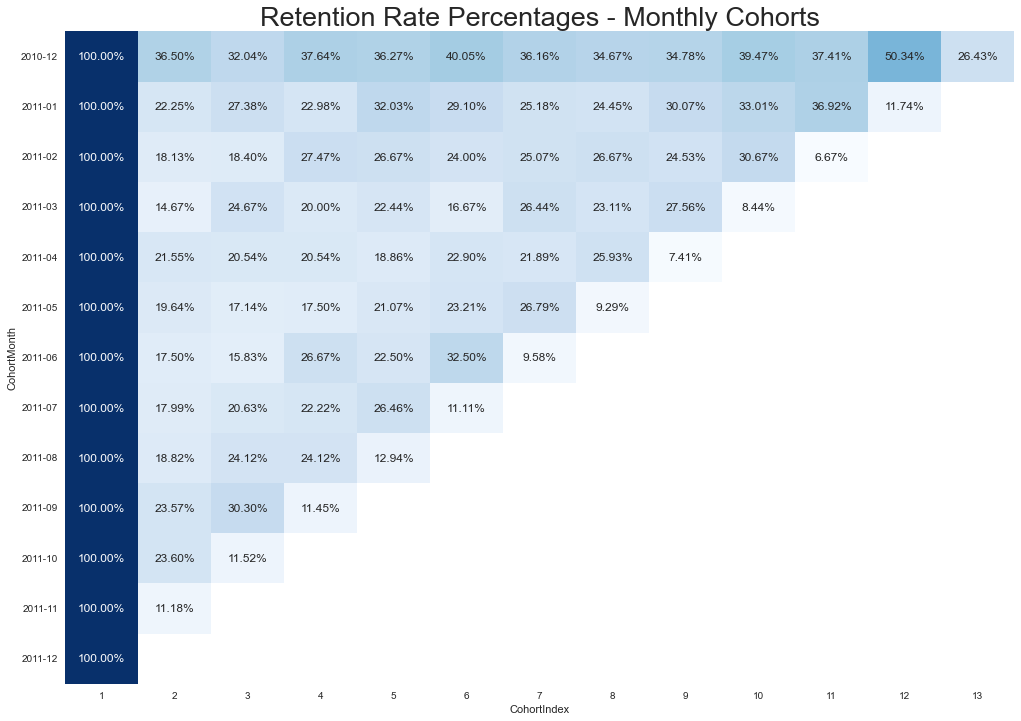

In [59]:
# visualization

plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(17,12))

sns.heatmap(retention,
            cmap='Blues',
            annot=True,
            fmt='.2%',
            annot_kws={'fontsize':12},
            cbar=False)


plt.title("Retention Rate Percentages - Monthly Cohorts", fontsize=27)
plt.yticks(rotation = 0)
plt.show()

- Let's look at above retention rate chart and interpret it.

- 40.05% of customers that made their first shopping in January 2011, use this company after five months.

In [60]:
customer_per_month = df.groupby('CohortMonth')['CustomerID'].nunique().values


customers = customer_per_month.cumsum()  # 每月累加的总和

customers = customers[::-1]

customers

array([4298, 4259, 3937, 3581, 3284, 3114, 2925, 2685, 2405, 2108, 1658,
       1283,  874], dtype=int64)

In [61]:
customers_in_month = df.groupby('CohortIndex')['CustomerID'].nunique()

customers_in_month

CohortIndex
1     4298
2      961
3      930
4      907
5      890
6      866
7      795
8      710
9      665
10     633
11     503
12     488
13     231
Name: CustomerID, dtype: int64

In [62]:
customers_in_month / customers

CohortIndex
1     1.000000
2     0.225640
3     0.236220
4     0.253281
5     0.271011
6     0.278099
7     0.271795
8     0.264432
9     0.276507
10    0.300285
11    0.303378
12    0.380359
13    0.264302
Name: CustomerID, dtype: float64

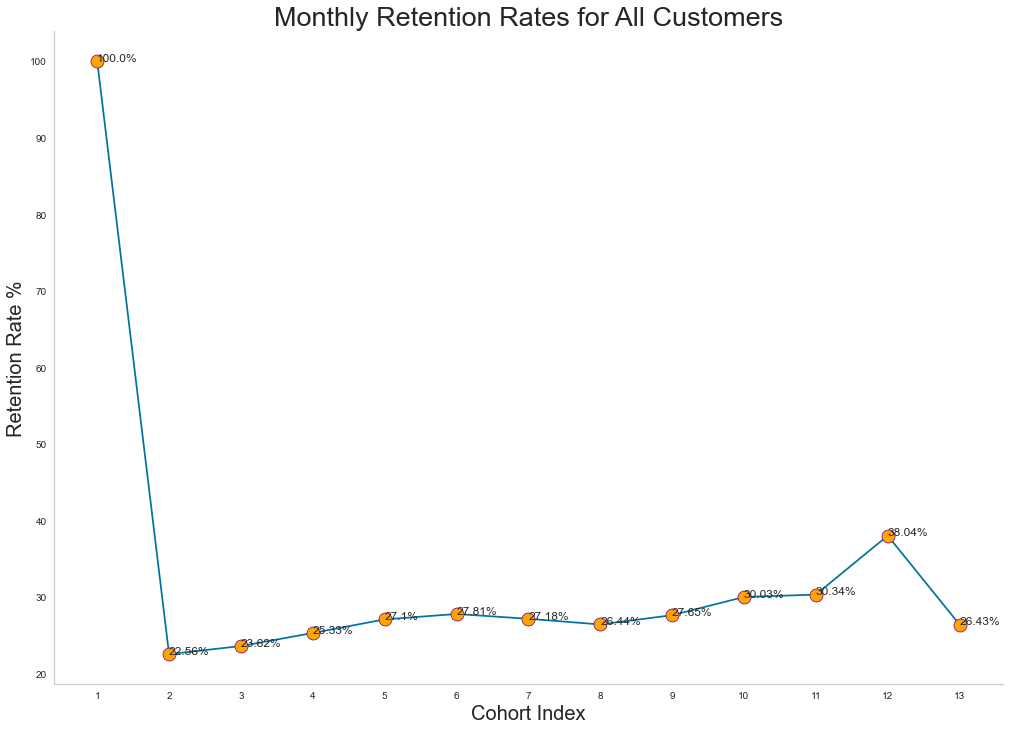

In [63]:
plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(17,12))

x = customers_in_month.index
y = 100*(customers_in_month / customers)

sns.lineplot(x=x,
             y=y,
             marker='o',
             markerfacecolor='orange',
             markeredgecolor='purple',
             markersize=13)

for x, y in zip(x,y):
    plt.text(x, y, s = str(round(y, 2)) + '%')  # 在各个点上显示数字
    
plt.xticks(ticks = customers_in_month.index)    
plt.xlabel("Cohort Index", fontsize=20)
plt.ylabel("Retention Rate %", fontsize=20)
plt.title("Monthly Retention Rates for All Customers",fontsize=27)

plt.grid(False)
sns.despine()
plt.show()

- From the plot above, we can find that **retention rate increases significantly** in the last months of the year. Probably, Thanksgiving, Black Friday and Christmas causes it. There are lots of special day at the end of year.

In [64]:
month_customer_price = df.groupby('InvoiceMonth').agg({'Total_Price':'sum',
                                                       'CustomerID':'nunique'})

month_customer_price

Total_Price  CustomerID
InvoiceMonth                         
2010-12-01      477001.27         874
2011-01-01      402460.88         728
2011-02-01      384935.12         746
2011-03-01      501435.63         959
2011-04-01      389147.37         843
2011-05-01      578653.77        1039
2011-06-01      502033.11         981
2011-07-01      495787.75         937
2011-08-01      512410.08         920
2011-09-01      775974.69        1246
2011-10-01      841921.28        1351
2011-11-01     1015510.90        1647
2011-12-01      288781.68         606

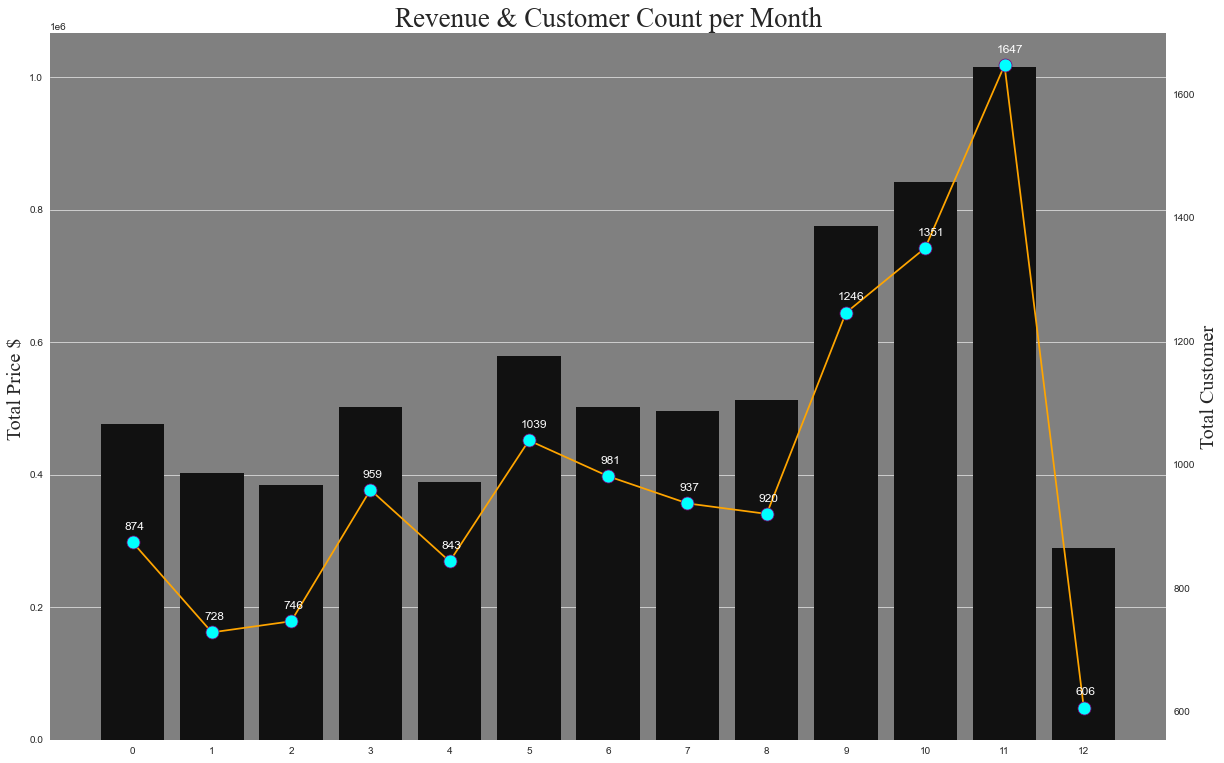

In [65]:
plt.rcParams['axes.facecolor'] = 'grey'
fig, ax = plt.subplots(figsize=(20,13))

sns.barplot(x = np.arange(len(month_customer_price.index)),
            y = month_customer_price['Total_Price'],
            ax=ax,
            color='k')

ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(month_customer_price.index)),
             y = month_customer_price['CustomerID'],
             ax=ax2,
             color='orange',
             marker='o',
             markersize=13,
             markerfacecolor='cyan',
             markeredgecolor='purple')

ax2.set_ylabel("Total Customer", fontname = "Times New Roman", fontsize=20)
ax.set_ylabel("Total Price $ ", fontname = "Times New Roman", fontsize=20)
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman", fontsize=27)


for x, y in zip(np.arange(len(month_customer_price.index)),  month_customer_price.CustomerID):
    ax2.text(x - 0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.grid(False)
plt.show()

## 3. Pareto Principle

> The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes (the “vital few”).


> Other names for this principle are the 80/20 rule, the law of the vital few, or the principle of factor sparsity.




- Lets implement Pareto's 80-20 rule to our dataset. We have two hypothesis:

    - ① 80% of company's revenue comes from 20% of **total customers.**
    
    - ② 80% of company's revenue comes from 20% of **total products.**
    
    
- To check these hypothesis, we need only two things.


    - 1) Individual sale records for customer/product

    - 2) Calculating cumulative sum for them
    

> Let's define below two functions for calculation and visualization.

   - **prepare_pareto_data** finds individual revenue per customer/product and calculates cumulative percentage of them.

   - **create_pareto_plot** takes output from these data and visualize it.

In [66]:
def prepare_pareto_data(df, col, price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    
    df_price = df_price.sort_values(price, ascending=False)
    
    df_price['CumulativePercentage'] = (df_price[price].cumsum() / 
                                        df_price[price].sum() * 100).round(2)
    
    return df_price

In [67]:
def create_pareto_plot(df, col, price, log=True):
    
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (17, 8), 
                           dpi = 300, 
                           facecolor = "lightgrey")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)),
                    y = np.log(df[price]),
                    ax = ax,
                    color = "steelblue")
        ax.set_ylabel("Total Price (Log - Scale)", fontsize=20)
        
        
        ax2 = ax.twinx()
        
        sns.lineplot(x = np.arange(len(df)),
                     y = df['CumulativePercentage'],
                     ax = ax2,
                     color='orange')
        
        ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
        
        ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)
        
        
        vlines = [int(len(df) * x / 10) for x in range(1, 10)]
        for vline in vlines: 
            ax2.axvline(vline,
                        color = "#008878", 
                        linestyle = "dashed", 
                        alpha = 0.1)
            
        interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
        
        ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)
        
        interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
        
        plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
        prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
        
        plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
        interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
        
        ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
        
        interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    
        plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
        
        plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)
        
        ax2.yaxis.set_major_formatter(PercentFormatter())
        ax.set_yticks([])
        plt.xticks([])
        ax.set_ylabel("Revenue", fontname = "Times New Roman")
        ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    
        subject = "Customers" if col == "CustomerID" else "Products"
        plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
        ax.set_xlabel(subject, fontname = "Times New Roman")
        
        sns.despine(left = True, right = True, bottom = True, top = True)
        plt.show()
        
    else:
        sns.barplot(x = np.arange(len(df)),
                    y = df[price],
                    ax = ax,
                    color = "steelblue")

        ax2 = ax.twinx()
                
        sns.lineplot(x = np.arange(len(df)),
                     y = df['CumulativePercentage'],
                     ax = ax2,
                     color='orange')
        
        ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
        
        ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)
        
        
        vlines = [int(len(df) * x / 10) for x in range(1, 10)]
        for vline in vlines: 
            ax2.axvline(vline,
                        color = "#008878", 
                        linestyle = "dashed", 
                        alpha = 0.1)
            
        interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
        
        ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)
        
        interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
        
        plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
        prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
        
        plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
        interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
        
        ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
        
        interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    
        plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
        
        plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

        ax2.yaxis.set_major_formatter(PercentFormatter())
        ax.set_yticks([])
        plt.xticks([])
        ax.set_ylabel("Revenue", fontname = "Times New Roman")
        ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    
        subject = "Customers" if col == "CustomerID" else "Products"
        plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
        ax.set_xlabel(subject, fontname = "Times New Roman")
        
        sns.despine(left = True, right = True, bottom = True, top = True)
        plt.show()

### 3.1Pareto Chart for Customers

In [68]:
customer_price = prepare_pareto_data(df, 'CustomerID', 'Total_Price')

customer_price

Total_Price  CumulativePercentage
CustomerID                                   
14646.0       189796.00                  2.65
14911.0       129795.43                  4.46
12415.0        81455.09                  5.60
14156.0        81329.92                  6.73
18102.0        80619.70                  7.86
...                 ...                   ...
14792.0            6.20                100.00
16454.0            5.90                100.00
16429.0            4.95                100.00
16738.0            3.75                100.00
16446.0            2.90                100.00

[4298 rows x 2 columns]

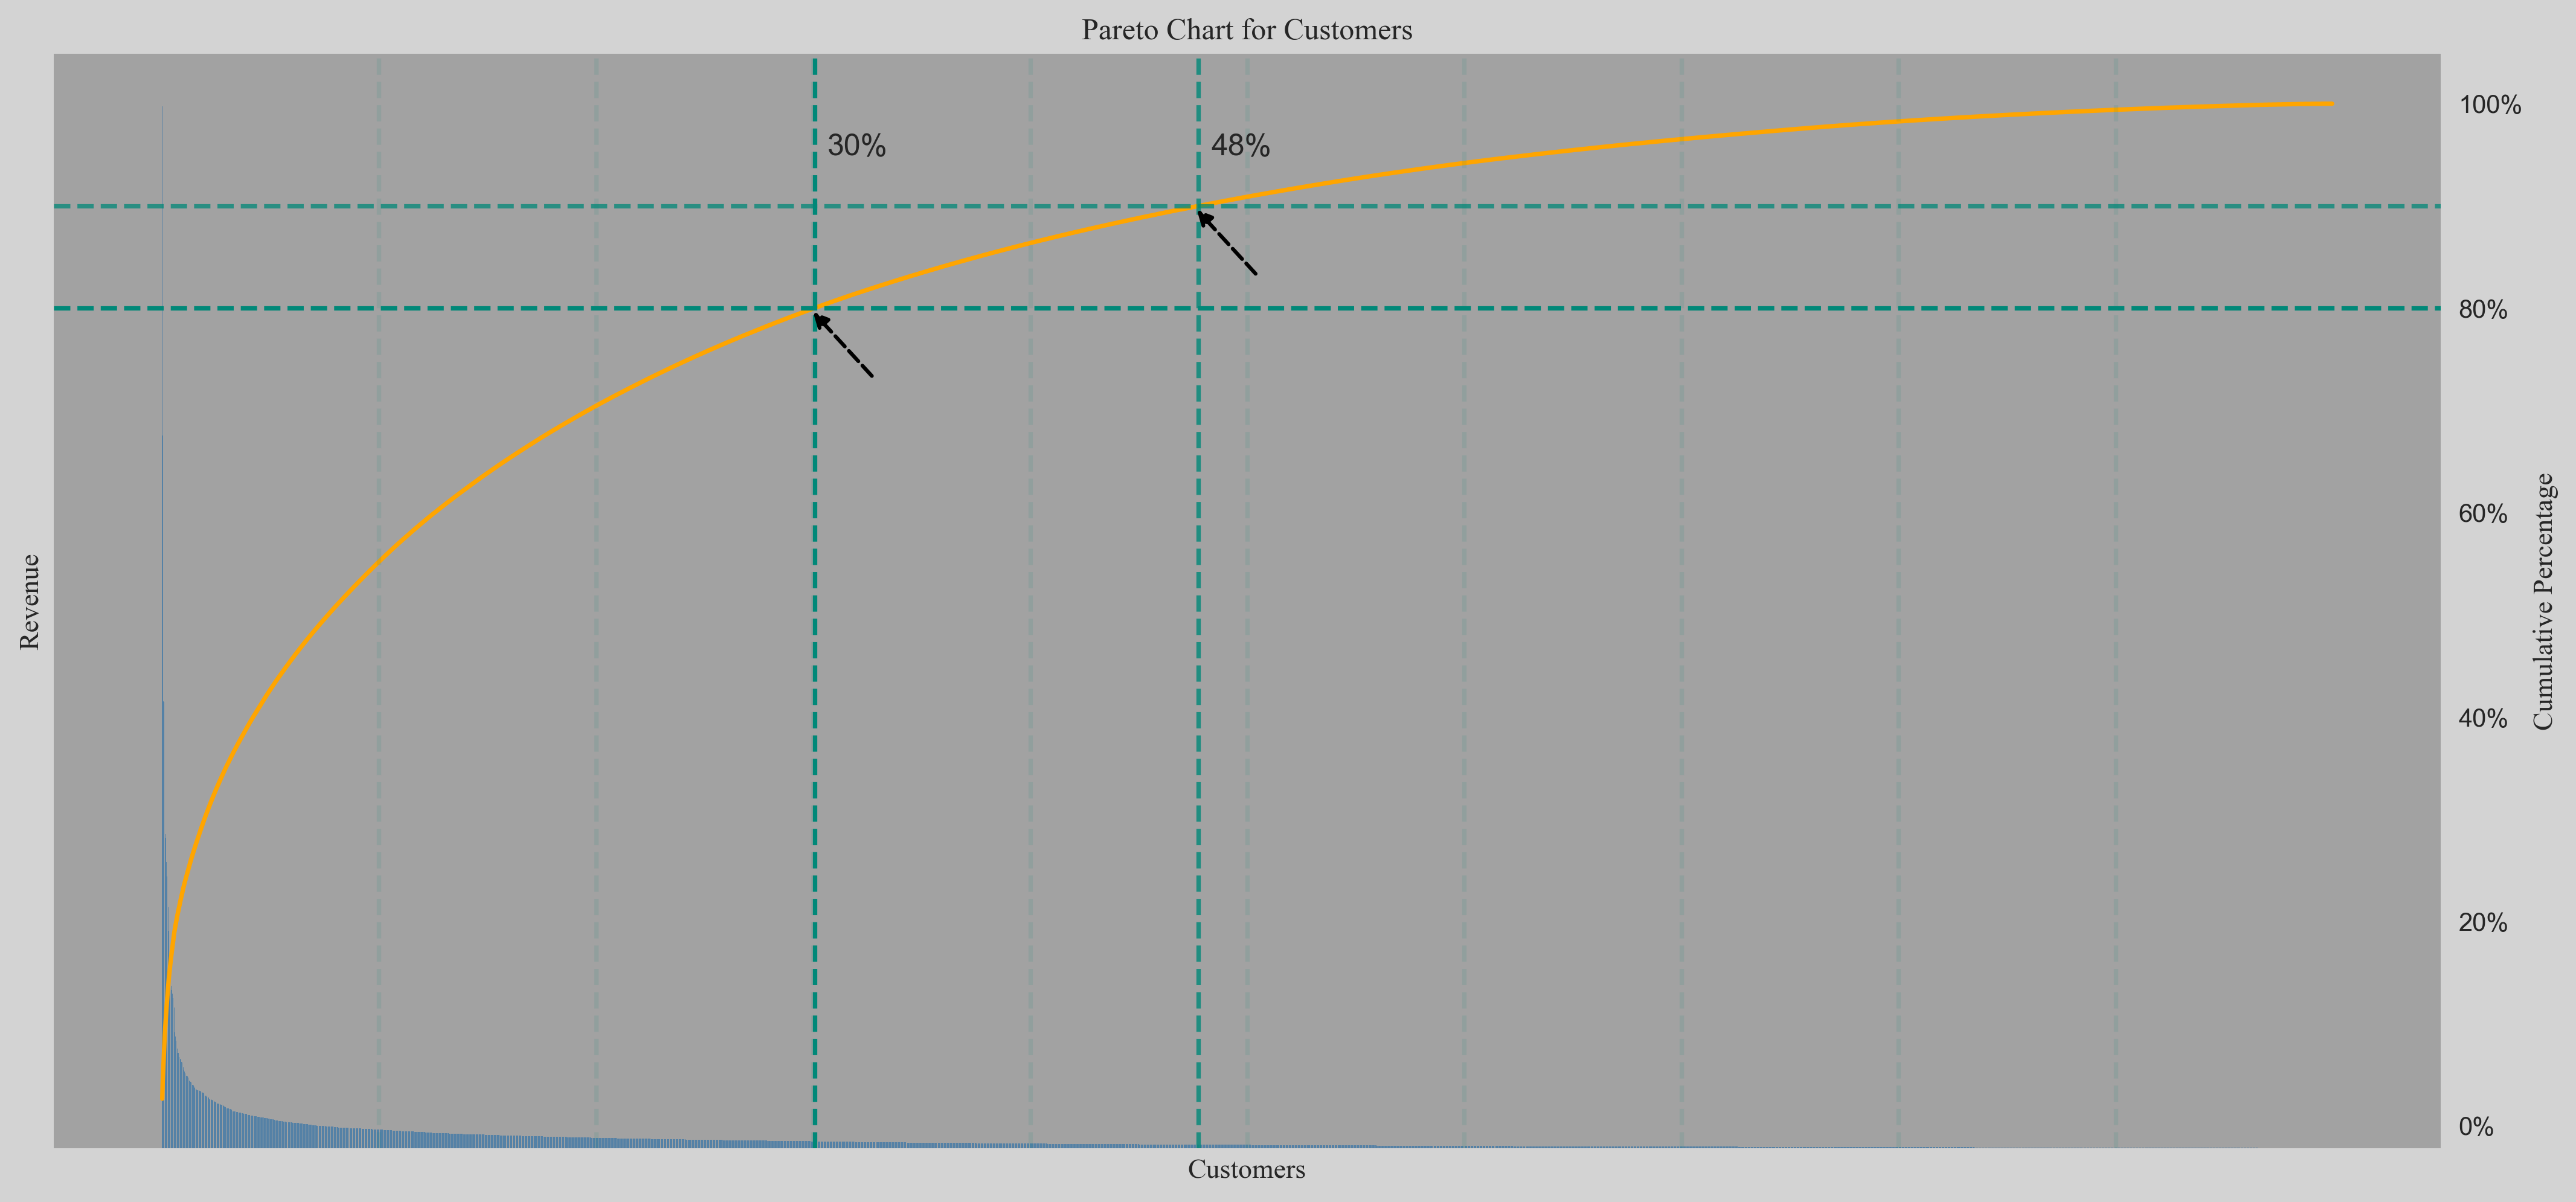

In [69]:
create_pareto_plot(customer_price, 'CustomerID','Total_Price', log = False)

- We can also plot it in log scale. It helps us for better visualization.

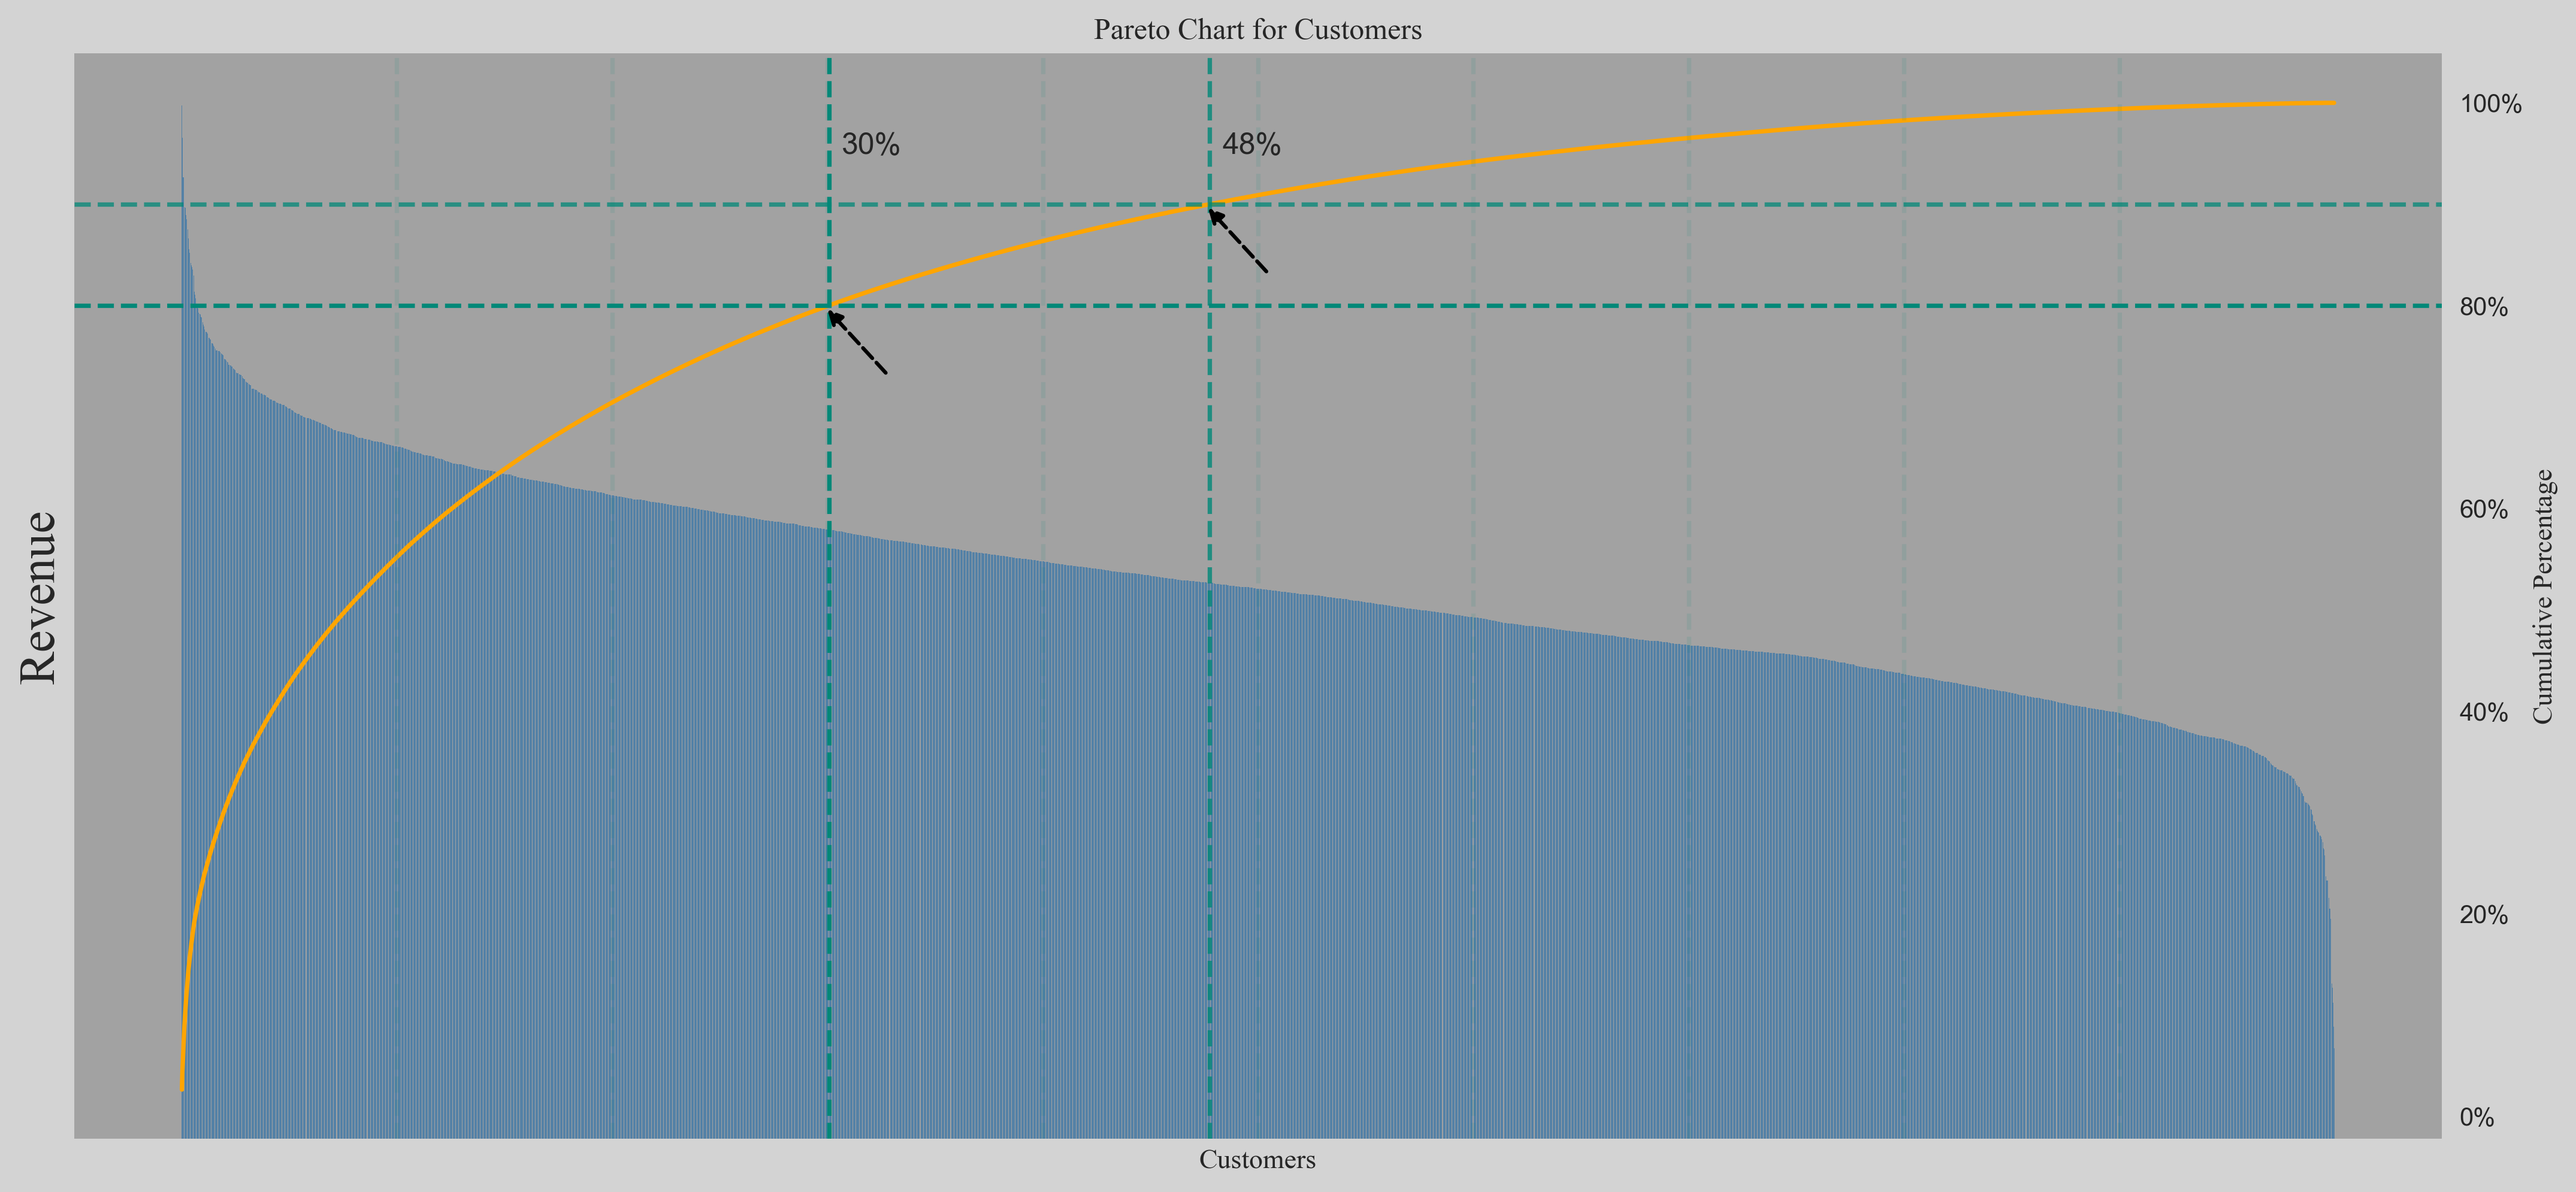

In [70]:
create_pareto_plot(customer_price, 'CustomerID', 'Total_Price', log = True)

- Well, lets interpret these two charts. Actually, we don't need to write a lot of things.

- We can see that 80% of company's revenue comes from top 30% of customers.

- Also, 90% of company's revenue comes from top 48% of customers.

### 3.2 Pareto Chart for Products

In [71]:
item_price = prepare_pareto_data(df, 'StockCode', 'Total_Price')

item_price

Total_Price  CumulativePercentage
StockCode                                   
22423        132100.75                  1.84
85123A        68282.78                  2.80
47566         61166.83                  3.65
85099B        57382.08                  4.45
79321         37464.27                  4.97
...                ...                   ...
84206B            0.95                100.00
90084             0.85                100.00
90104             0.85                100.00
21268             0.84                100.00
84227             0.42                100.00

[3629 rows x 2 columns]

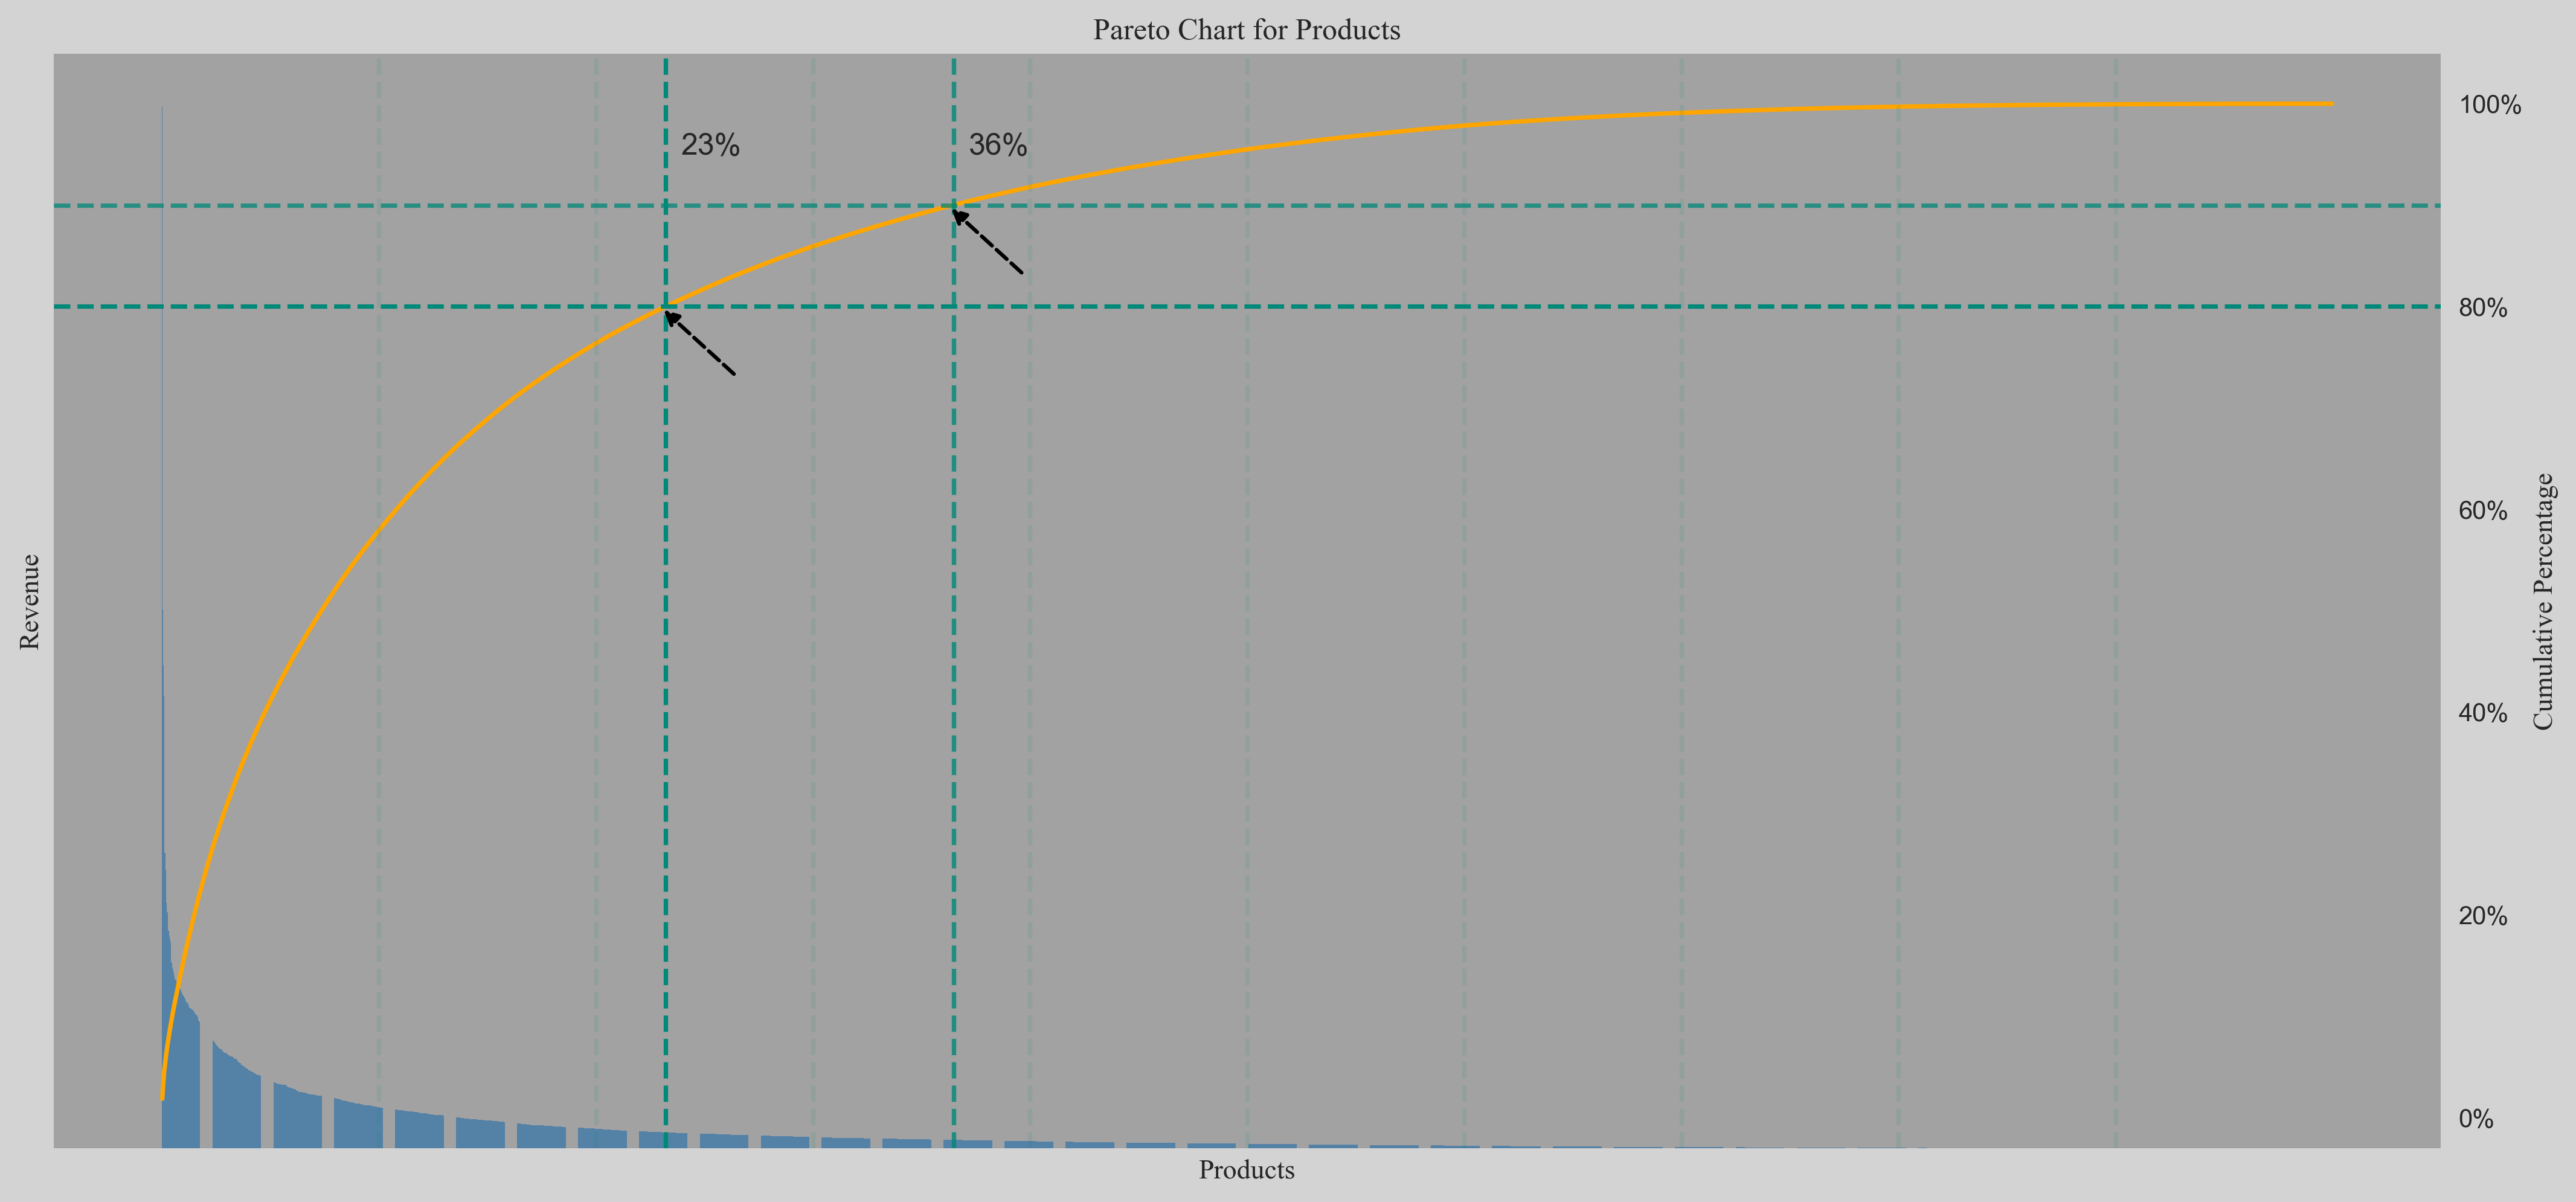

In [72]:
create_pareto_plot(item_price, 'StockCode', 'Total_Price', log = False)

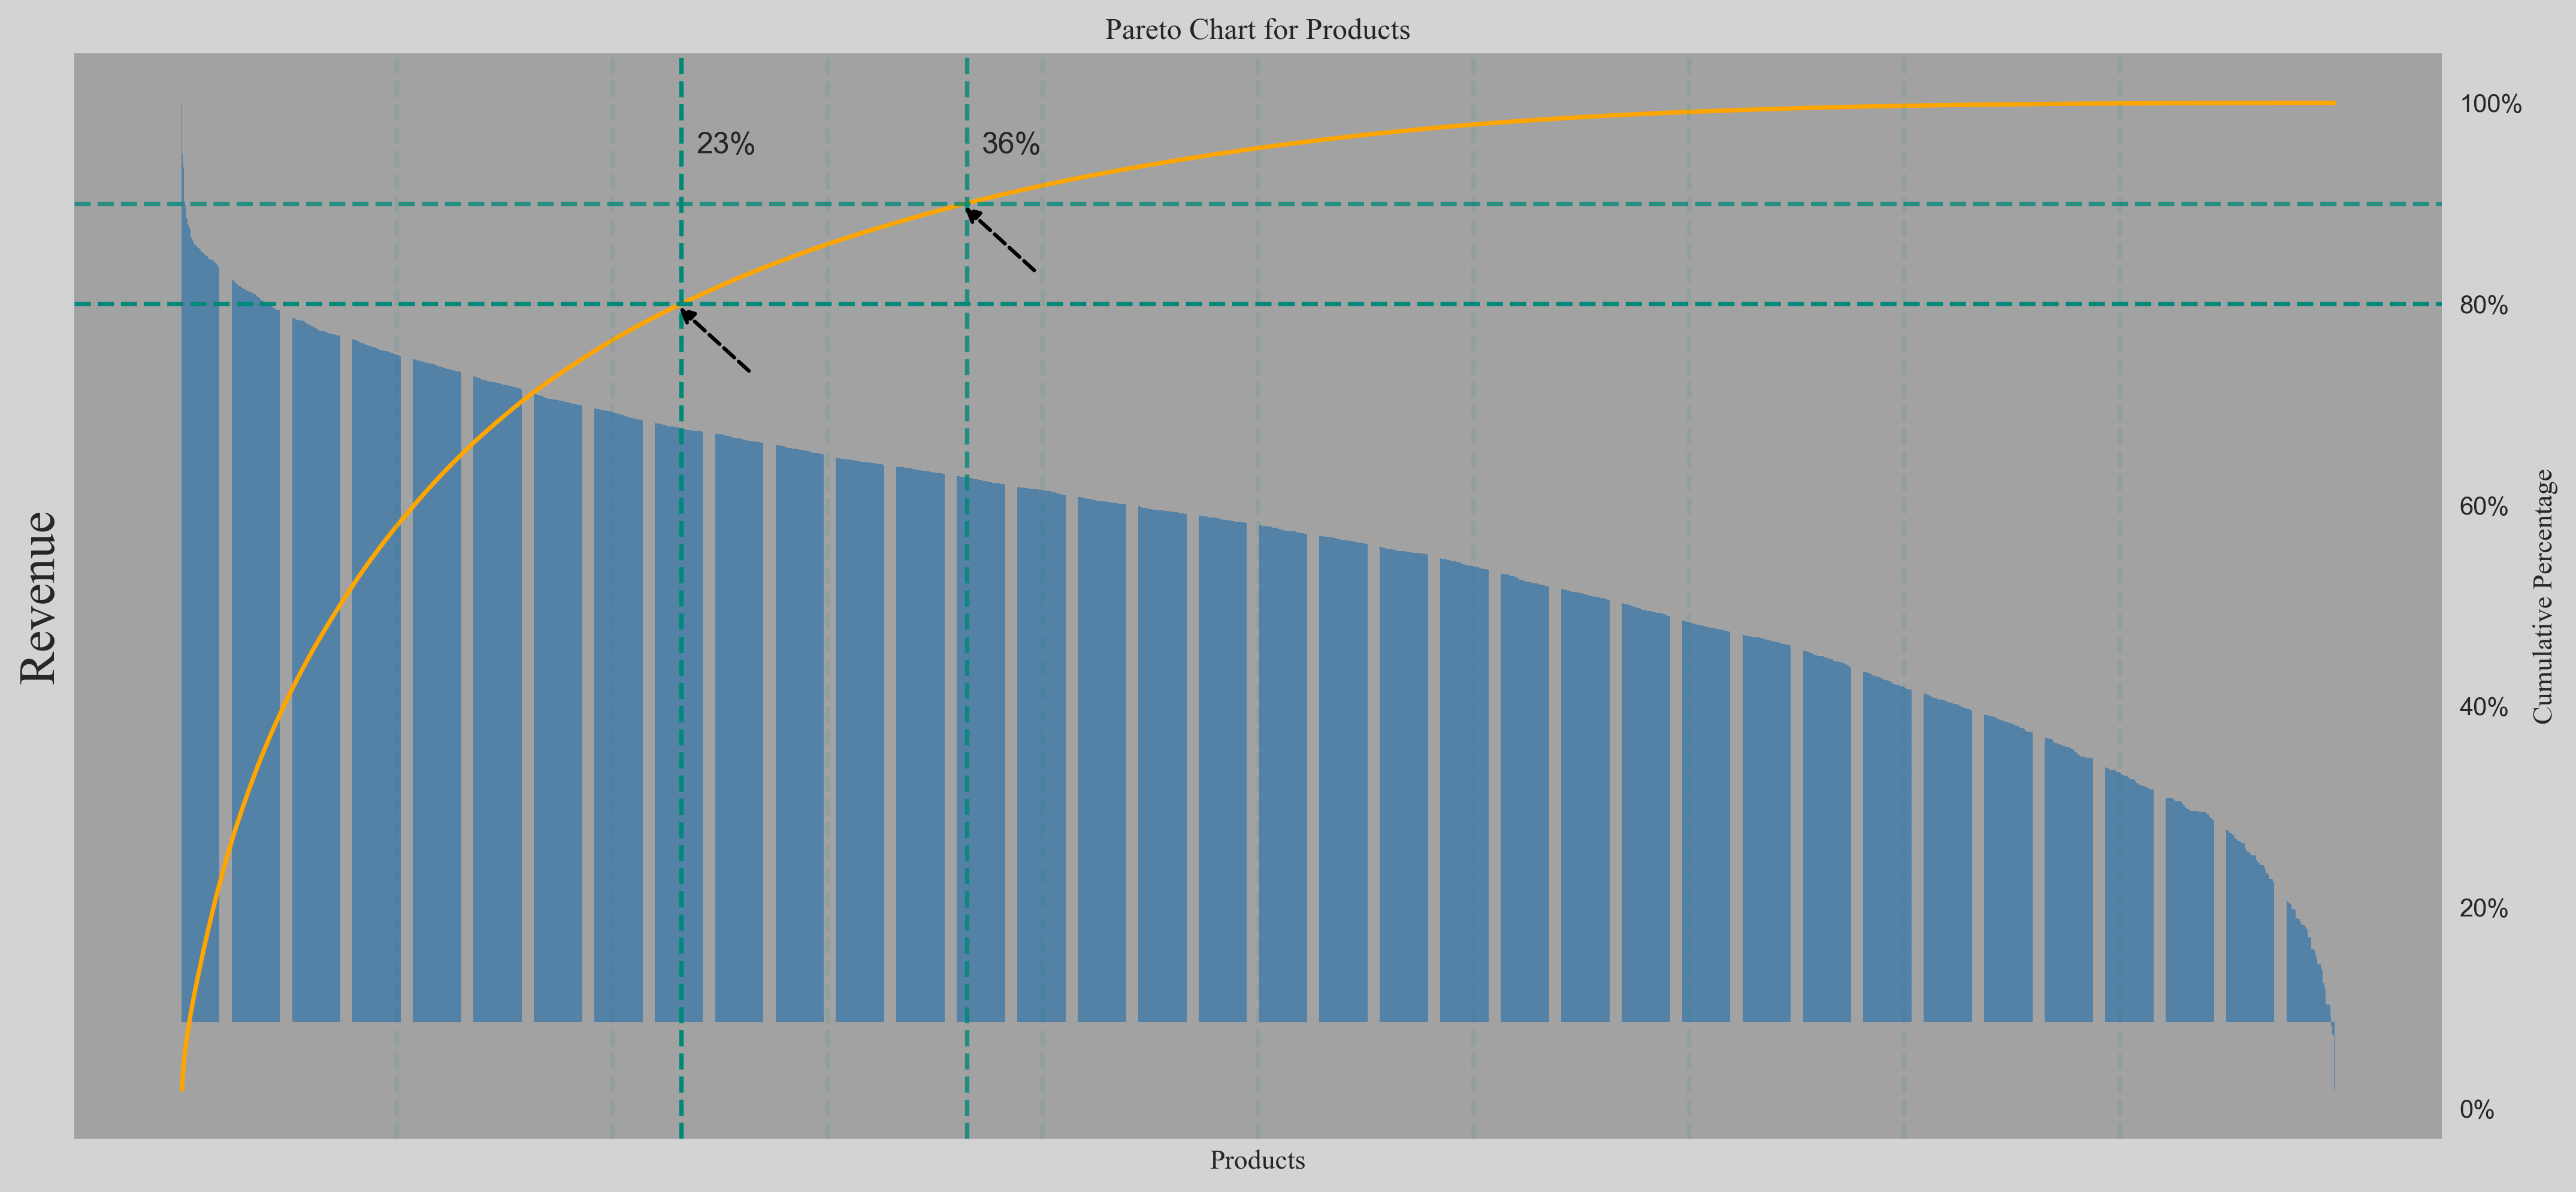

In [73]:
create_pareto_plot(item_price, 'StockCode', 'Total_Price')

- We can see that 80% of company's revenue comes from top 23% of products that have most revenue.

- Also, 90% of company's revenue comes from 36% of products that have most revenue.

- Maybe, if the company reduce by half its variety of items, revenue couldn't decrease significantly.

In [74]:
top_customers = customer_price[customer_price['CumulativePercentage'] <= 80].index.tolist()

products_for_top_customers = df[df['CustomerID'].isin(top_customers)]['Description'].drop_duplicates().values.tolist()

products_for_other_customers = df[~df['CustomerID'].isin(top_customers)]['Description'].drop_duplicates().values.tolist()

### 4. RFM Analysis


- Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

    - **Recency**: How recently a customer has made a purchase

    - **Frequency**: How often a customer makes a purchase

    - **Monetary Value**: How much money a customer spends on purchases



- RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.


* https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp


* https://clevertap.com/blog/rfm-analysis/

### 4.1 Let's perform RFM Analysis on our data.

- Preparing RFM table

In [75]:
print('Min date: {} \nMax date: {}'.format(df['InvoiceDate'].min(), df['InvoiceDate'].max()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00


In [76]:
last_day = df['InvoiceDate'].max() + dt.timedelta(days = 1)

last_day

Timestamp('2011-12-10 12:50:00')

In [77]:
RFM_TABLE = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (last_day - x.max()).days,
                                          'InvoiceNo': 'nunique',
                                          'Total_Price': 'sum'})

RFM_TABLE

InvoiceDate  InvoiceNo  Total_Price
CustomerID                                     
12347.0               2          7      4060.40
12348.0              75          4      1437.24
12349.0              19          1      1417.60
12350.0             310          1       294.40
12352.0              36          7      1385.74
...                 ...        ...          ...
18280.0             278          1       180.60
18281.0             181          1        80.82
18282.0               8          2       178.05
18283.0               4         16      2088.93
18287.0              43          3      1837.28

[4298 rows x 3 columns]

In [78]:
RFM_TABLE.rename(columns = {'InvoiceDate':'Recency',
                            'InvoiceNo':'Frequency',
                            'Total_Price':'Monetary'},
                 inplace=True)

RFM_TABLE

Recency  Frequency  Monetary
CustomerID                              
12347.0           2          7   4060.40
12348.0          75          4   1437.24
12349.0          19          1   1417.60
12350.0         310          1    294.40
12352.0          36          7   1385.74
...             ...        ...       ...
18280.0         278          1    180.60
18281.0         181          1     80.82
18282.0           8          2    178.05
18283.0           4         16   2088.93
18287.0          43          3   1837.28

[4298 rows x 3 columns]

- Then let's score customers based on these three indicators.

In [79]:
r_labels = range(5, 0, -1)

fm_labels = range(1, 6)


RFM_TABLE['R'] = pd.qcut(RFM_TABLE['Recency'], 5, labels=r_labels)


RFM_TABLE['F'] = pd.qcut(RFM_TABLE['Frequency'].rank(method='first'), 5, labels=fm_labels)


RFM_TABLE['M'] = pd.qcut(RFM_TABLE['Monetary'], 5, labels=fm_labels)


RFM_TABLE

Recency  Frequency  Monetary  R  F  M
CustomerID                                       
12347.0           2          7   4060.40  5  5  5
12348.0          75          4   1437.24  2  4  4
12349.0          19          1   1417.60  4  1  4
12350.0         310          1    294.40  1  1  2
12352.0          36          7   1385.74  3  5  4
...             ...        ...       ... .. .. ..
18280.0         278          1    180.60  1  2  1
18281.0         181          1     80.82  1  2  1
18282.0           8          2    178.05  5  3  1
18283.0           4         16   2088.93  5  5  5
18287.0          43          3   1837.28  3  4  4

[4298 rows x 6 columns]

In [80]:
RFM_TABLE['RFM_Segment'] = RFM_TABLE['R'].astype(str) +'-'+ RFM_TABLE['F'].astype(str) +'-'+ RFM_TABLE['M'].astype(str)


RFM_TABLE['RFM_Score'] = RFM_TABLE[['R','F','M']].sum(axis=1)

RFM_TABLE

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
CustomerID                                                              
12347.0           2          7   4060.40  5  5  5       5-5-5         15
12348.0          75          4   1437.24  2  4  4       2-4-4         10
12349.0          19          1   1417.60  4  1  4       4-1-4          9
12350.0         310          1    294.40  1  1  2       1-1-2          4
12352.0          36          7   1385.74  3  5  4       3-5-4         12
...             ...        ...       ... .. .. ..         ...        ...
18280.0         278          1    180.60  1  2  1       1-2-1          4
18281.0         181          1     80.82  1  2  1       1-2-1          4
18282.0           8          2    178.05  5  3  1       5-3-1          9
18283.0           4         16   2088.93  5  5  5       5-5-5         15
18287.0          43          3   1837.28  3  4  4       3-4-4         11

[4298 rows x 8 columns]

### 4.2 RFM segments

- **Champions**: Bought recently, buy often and spend the most


- **Loyal customers**: Buy on a regular basis. Responsive to promotions.


- **Potential loyalist**: Recent customers with average frequency.


- **Recent customers**: Bought most recently, but not often.


- **Promising**: Recent shoppers, but haven’t spent much.


- **Needs attention**: Above average recency, frequency and monetary values. May not have bought very recently though.


- **About to sleep**: Below average recency and frequency. Will lose them if not reactivated.


- **At risk**: Some time since they’ve purchased. Need to bring them back!


- **Can’t lose them**: Used to purchase frequently but haven’t returned for a long time.


- **Hibernating**: Last purchase was long back and low number of orders. May be lost.


* https://futurice.com/blog/know-your-customers-with-rfm

> I don't know is it right source of below segmentation map dict, but I found that code here. 

* https://guillaume-martin.github.io/rfm-segmentation-with-python.html

In [81]:
segt_map = {r'[1-2][1-2]':'Hibernating',
           r'[1-2][3-4]':'At-Risk',
           r'[1-2]5':'Cannot lose them',
           r'3[1-2]':'About To Sleep',
           r'33':'Need Attention',
           r'[3-4][4-5]':'Loyal Customers',
           r'41':'Promising',
           r'51':'New Customers',
           r'[4-5][2-3]':'Potential Loyalists',
           r'5[4-5]':'Champions'}

In [82]:
RFM_TABLE['Segment'] = RFM_TABLE['R'].astype(str) + RFM_TABLE['F'].astype(str)

RFM_TABLE['Segment'] = RFM_TABLE['Segment'].replace(segt_map,
                                                    regex=True)

RFM_TABLE

Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score  \
CustomerID                                                                 
12347.0           2          7   4060.40  5  5  5       5-5-5         15   
12348.0          75          4   1437.24  2  4  4       2-4-4         10   
12349.0          19          1   1417.60  4  1  4       4-1-4          9   
12350.0         310          1    294.40  1  1  2       1-1-2          4   
12352.0          36          7   1385.74  3  5  4       3-5-4         12   
...             ...        ...       ... .. .. ..         ...        ...   
18280.0         278          1    180.60  1  2  1       1-2-1          4   
18281.0         181          1     80.82  1  2  1       1-2-1          4   
18282.0           8          2    178.05  5  3  1       5-3-1          9   
18283.0           4         16   2088.93  5  5  5       5-5-5         15   
18287.0          43          3   1837.28  3  4  4       3-4-4         11   

                        Segment  
CustomerID                       
12347.0               Champions  
12348.0                 At-Risk  
12349.0               Promising  
12350.0             Hibernating  
12352.0         Loyal Customers  
...                         ...  
18280.0             Hibernating  
18281.0             Hibernating  
18282.0     Potential Loyalists  
18283.0               Champions  
18287.0         Loyal Customers  

[4298 rows x 9 columns]

### 4.3 Visualizing RFM Grid

- https://www.wigzo.com/blog/wp-content/uploads/2021/06/RFM-Analysis.jpg

In [83]:
RFM_COORDINATES = {'Champions':[3,5,0.8,1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

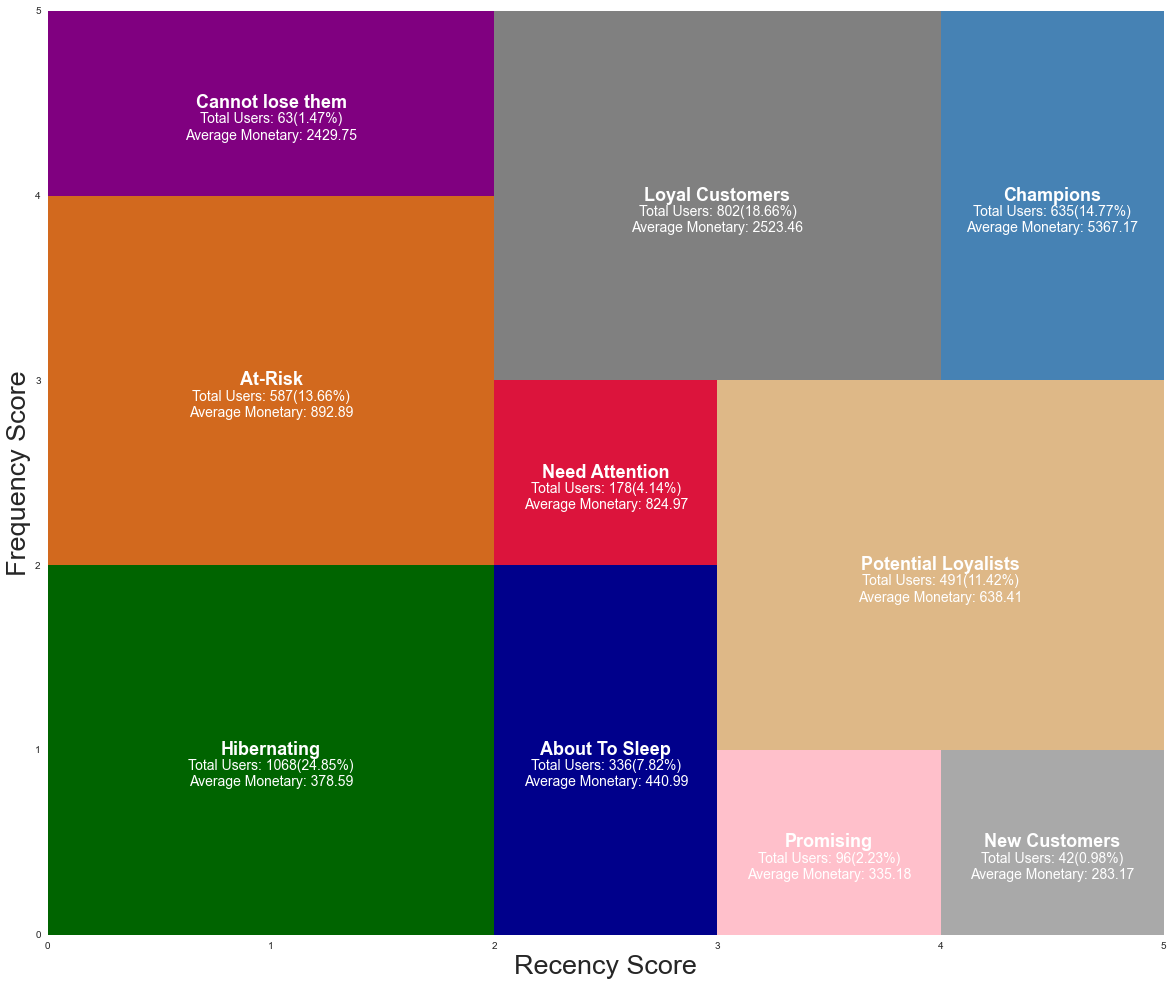

In [84]:
fig, ax = plt.subplots(figsize=(20,17))

ax.set_xlim([0,5])
ax.set_ylim([0,5])

plt.rcParams['axes.facecolor'] = 'white'

palette = ["steelblue", "grey", "purple", "chocolate",  "darkgreen", 
           "darkblue", "pink", "darkgrey", "burlywood", "crimson"]

for key, color in zip(RFM_COORDINATES.keys(), palette[:10]):
    
    coordinates = RFM_COORDINATES[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = RFM_TABLE[RFM_TABLE['Segment'] == key].shape[0]
    users_percentage = (RFM_TABLE[RFM_TABLE['Segment'] == key].shape[0] / RFM_TABLE.shape[0]) * 100
    avg_monetary = RFM_TABLE[RFM_TABLE['Segment'] == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score", fontsize=27)
    ax.set_ylabel("Frequency Score", fontsize=27)
    
sns.despine(left = True, bottom = True)
plt.show()


### 4.4 Visualizing RFM Segments

In [85]:
rfm_table2 = RFM_TABLE.reset_index()

rfm_monetary_size = rfm_table2.groupby('Segment').agg({'Monetary':'mean',
                                                       'CustomerID':'nunique'})
rfm_monetary_size

Monetary  CustomerID
Segment                                     
About To Sleep        440.993839         336
At-Risk               892.892606         587
Cannot lose them     2429.746667          63
Champions            5367.173685         635
Hibernating           378.587182        1068
Loyal Customers      2523.460599         802
Need Attention        824.973764         178
New Customers         283.170476          42
Potential Loyalists   638.411935         491
Promising             335.177604          96

In [86]:
rfm_monetary_size.rename(columns = {'Monetary':'MeanMonetary',
                                    'CustomerID':'CustomerCount'},
                         inplace=True)

rfm_monetary_size = rfm_monetary_size.sort_values(by='MeanMonetary',
                                                  ascending=False)

rfm_monetary_size

MeanMonetary  CustomerCount
Segment                                         
Champions             5367.173685            635
Loyal Customers       2523.460599            802
Cannot lose them      2429.746667             63
At-Risk                892.892606            587
Need Attention         824.973764            178
Potential Loyalists    638.411935            491
About To Sleep         440.993839            336
Hibernating            378.587182           1068
Promising              335.177604             96
New Customers          283.170476             42

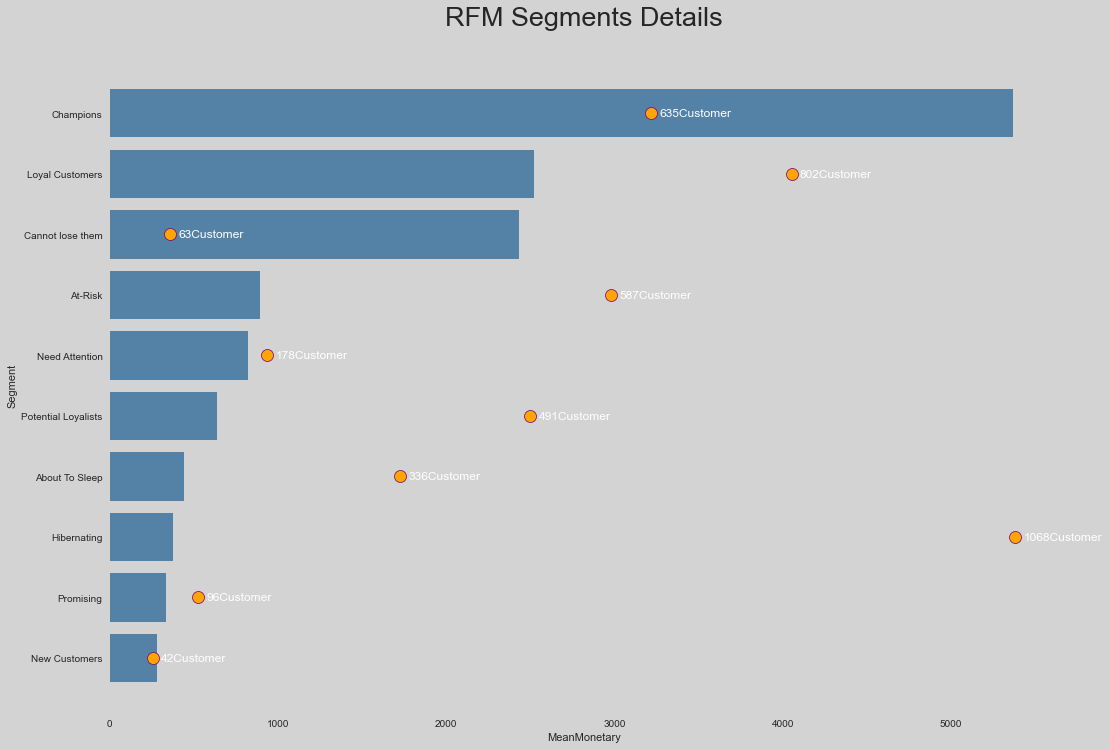

In [87]:
plt.rcParams['axes.facecolor'] = 'lightgrey'
fig, ax = plt.subplots(figsize=(17,12),
                       facecolor='lightgrey')

sns.barplot(x=rfm_monetary_size['MeanMonetary'],
            y=rfm_monetary_size.index,
            ax=ax,
            color='steelblue')

ax2 = ax.twiny()
sns.lineplot(x=rfm_monetary_size['CustomerCount'],
             y=rfm_monetary_size.index,
             ax=ax2,
             marker='o',
             markersize=12,
             lw=0,
             color='orange',
             markeredgecolor='purple')

ax2.axis('off')

for y, x in list(enumerate(rfm_monetary_size['CustomerCount'])):
    ax2.text(x+10, y+0.05, 
             str(x) + 'Customer',
             color='white',
             fontweight='normal')
    
    
plt.title('RFM Segments Details', fontsize=27)
sns.despine(left=True,
            right=True,
            bottom=True,
            top=True)

plt.show()

In [88]:
rfm_table2

CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Segment  \
0        12347.0        2          7   4060.40  5  5  5       5-5-5   
1        12348.0       75          4   1437.24  2  4  4       2-4-4   
2        12349.0       19          1   1417.60  4  1  4       4-1-4   
3        12350.0      310          1    294.40  1  1  2       1-1-2   
4        12352.0       36          7   1385.74  3  5  4       3-5-4   
...          ...      ...        ...       ... .. .. ..         ...   
4293     18280.0      278          1    180.60  1  2  1       1-2-1   
4294     18281.0      181          1     80.82  1  2  1       1-2-1   
4295     18282.0        8          2    178.05  5  3  1       5-3-1   
4296     18283.0        4         16   2088.93  5  5  5       5-5-5   
4297     18287.0       43          3   1837.28  3  4  4       3-4-4   

      RFM_Score              Segment  
0            15            Champions  
1            10              At-Risk  
2             9            Promising  
3             4          Hibernating  
4            12      Loyal Customers  
...         ...                  ...  
4293          4          Hibernating  
4294          4          Hibernating  
4295          9  Potential Loyalists  
4296         15            Champions  
4297         11      Loyal Customers  

[4298 rows x 10 columns]

In [89]:
RFM = rfm_table2.groupby('Segment').agg({'CustomerID':'nunique',
                                         'Recency':'mean',
                                         'Frequency':'mean',
                                         'Monetary':'mean'})

RFM.rename(columns = {'CustomerID':'Segment Size'},
           inplace=True)

In [90]:
cm = sns.light_palette('lightgrey', as_cmap=True)

RFM.T.style.background_gradient(cmap = cm,
                                axis=1).set_precision(2).highlight_min(axis=1,
                                                                       color='lightblue').highlight_max(axis=1,
                                                                                                        color='orange')

D:\A\envs\py37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


<Figure size 1440x1224 with 0 Axes>

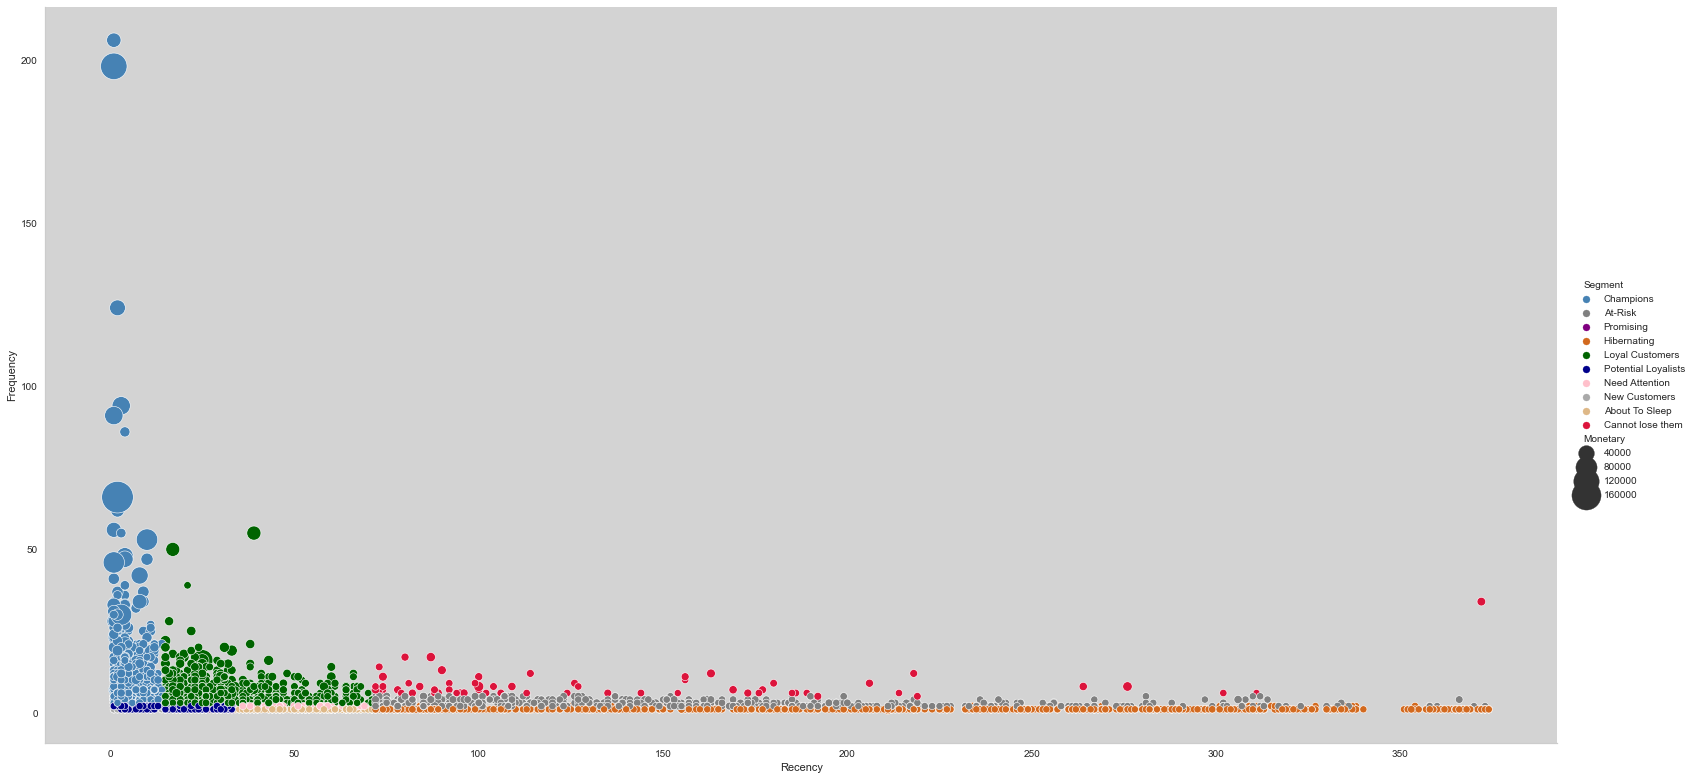

In [91]:
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(20,17))

sns.relplot(x = 'Recency',
            y = 'Frequency',
            hue = 'Segment',
            size = 'Monetary',
            data = rfm_table2,
            palette = palette,      # code 第90中定义过palette
            height = 11,
            aspect = 2,
            sizes=(50, 1000)) 

plt.show()

In [92]:
monetary_per_segment = (rfm_table2.groupby('Segment')['Monetary'].sum() / 
                        rfm_table2.groupby('Segment')['Monetary'].sum().sum()).sort_values(ascending=False)

monetary_per_segment

Segment
Champions              0.475597
Loyal Customers        0.282417
At-Risk                0.073140
Hibernating            0.056423
Potential Loyalists    0.043742
Cannot lose them       0.021361
About To Sleep         0.020677
Need Attention         0.020492
Promising              0.004490
New Customers          0.001660
Name: Monetary, dtype: float64

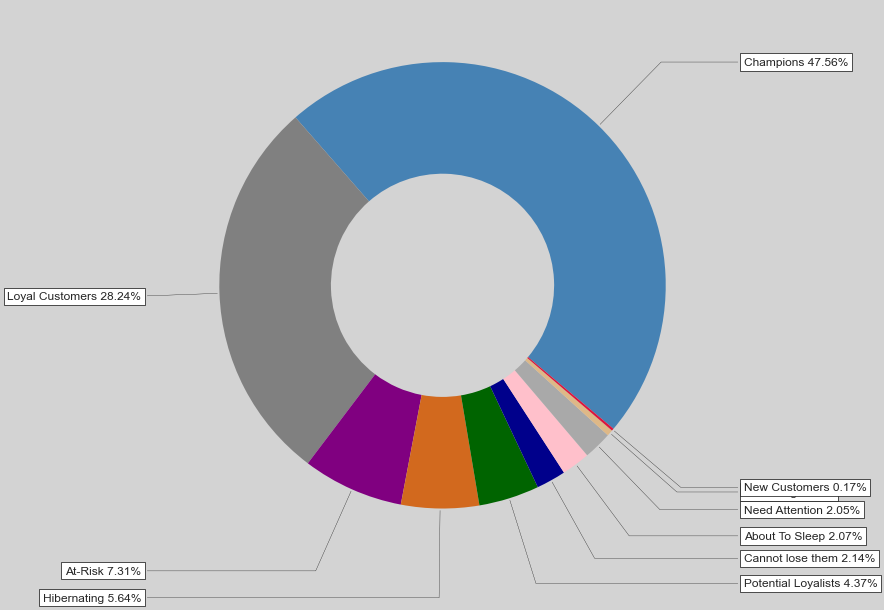

In [93]:
fig, ax = plt.subplots(figsize = (10, 11), facecolor = "lightgrey")

wedges, texts = ax.pie(monetary_per_segment.values, 
                       wedgeprops=dict(width=0.5), 
                       startangle=-40,
                       normalize=False,
                       colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3",
                  fc="w",
                  ec="k",
                  lw=0.72)

kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    
    y = np.sin(np.deg2rad(ang))
    
    x = np.cos(np.deg2rad(ang))
    
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%",
                xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
plt.show()

- 47.5% of total revenue comes from "Champions" segment, and 28% of total revenue comes from "Loyal Customers" segment. These two segments have 75% of company's total revenue.

In [94]:
rfm_clustering = rfm_table2[["Recency", "Frequency", "Monetary", "Segment"]]

for col in ["Recency", "Frequency", "Monetary"]:
    
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1, 1))
    
rfm_melted = pd.melt(rfm_clustering,
                     id_vars = "Segment",
                     value_vars = ["Recency", "Frequency", "Monetary"],
                     var_name = "RFM",
                     value_name = "Value")

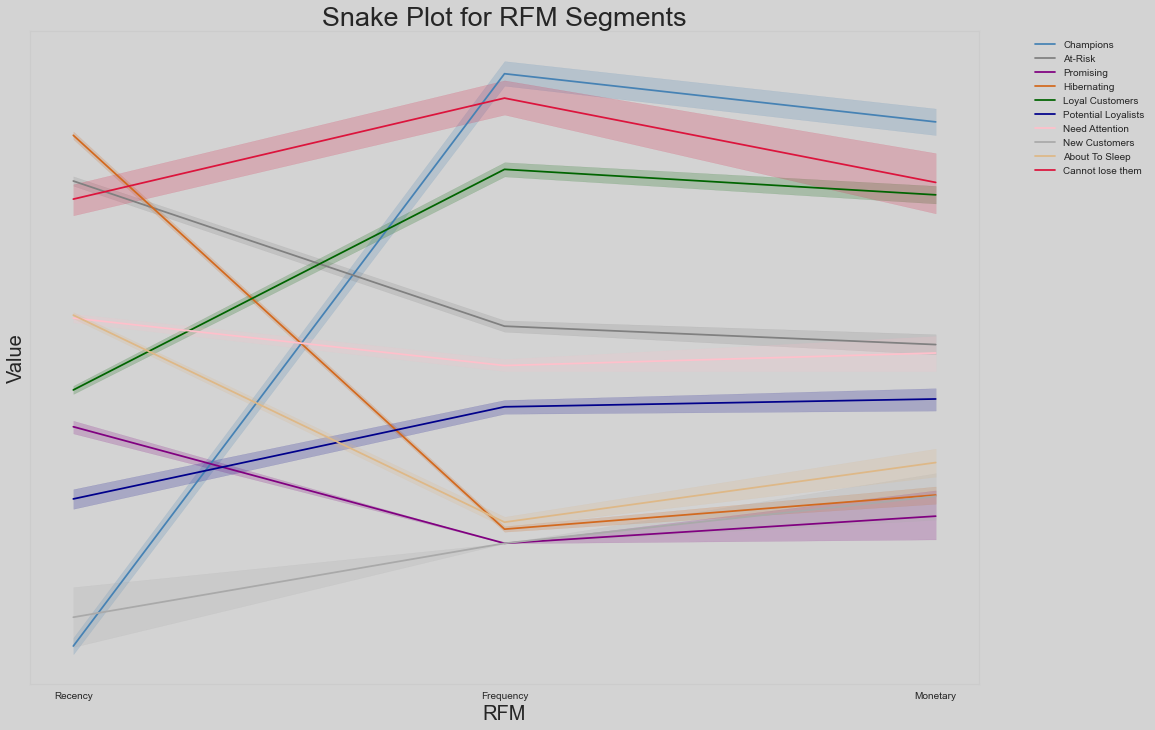

In [95]:
fig, ax = plt.subplots(figsize = (17,12), facecolor = "lightgrey")
ax.set_facecolor("lightgrey")

sns.lineplot(x = "RFM",
             y = "Value",
             hue = "Segment",
             data = rfm_melted,
             palette = palette)

ax.legend(bbox_to_anchor = (1.05, 1),
          loc = 'best',
          borderaxespad = 0.5)

ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments", fontsize=27)
ax.set_xlabel('RFM', fontsize=20)
ax.set_ylabel('Value', fontsize=20)

plt.show()

### 4.5 Customer Segmentation with using RFM Metrics

In [96]:
features = ['Recency','Frequency','Monetary']

kmeans_ = KMeans(init = 'k-means++',
                 random_state = 42)

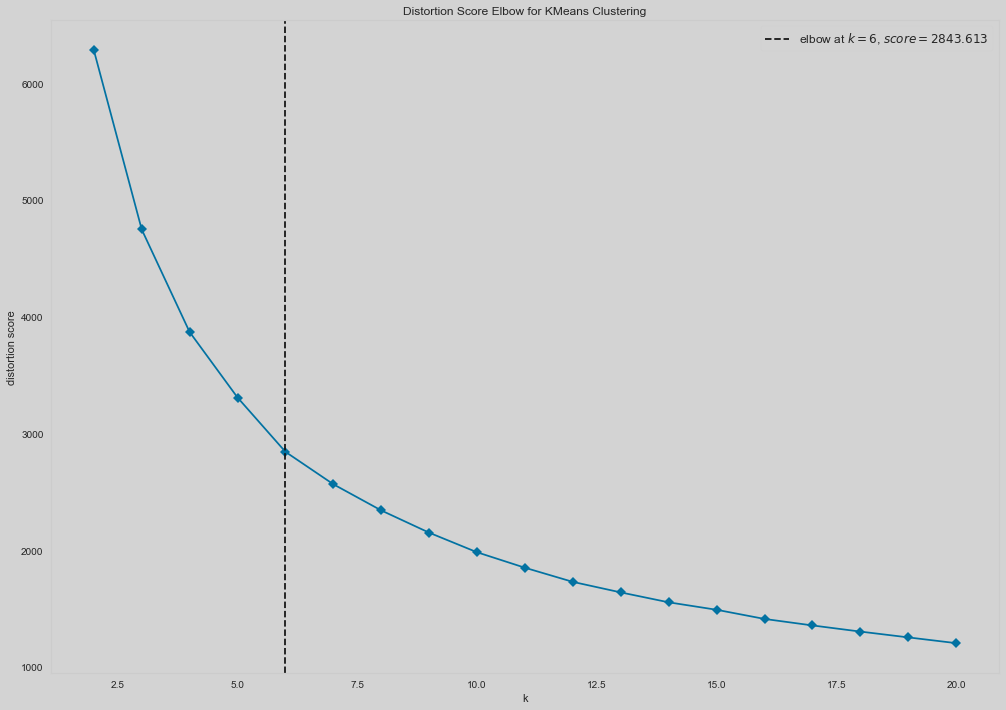

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
fig, ax = plt.subplots(figsize=(17,12), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.grid(False)

visualizer = KElbowVisualizer(kmeans_, k=(2,21), timings=False)

visualizer.fit(rfm_clustering[features])

visualizer.show()

In [98]:
kmeans = KMeans(n_clusters=6,
                random_state=42)
kmeans.fit(rfm_clustering[features])

cluster = kmeans.labels_

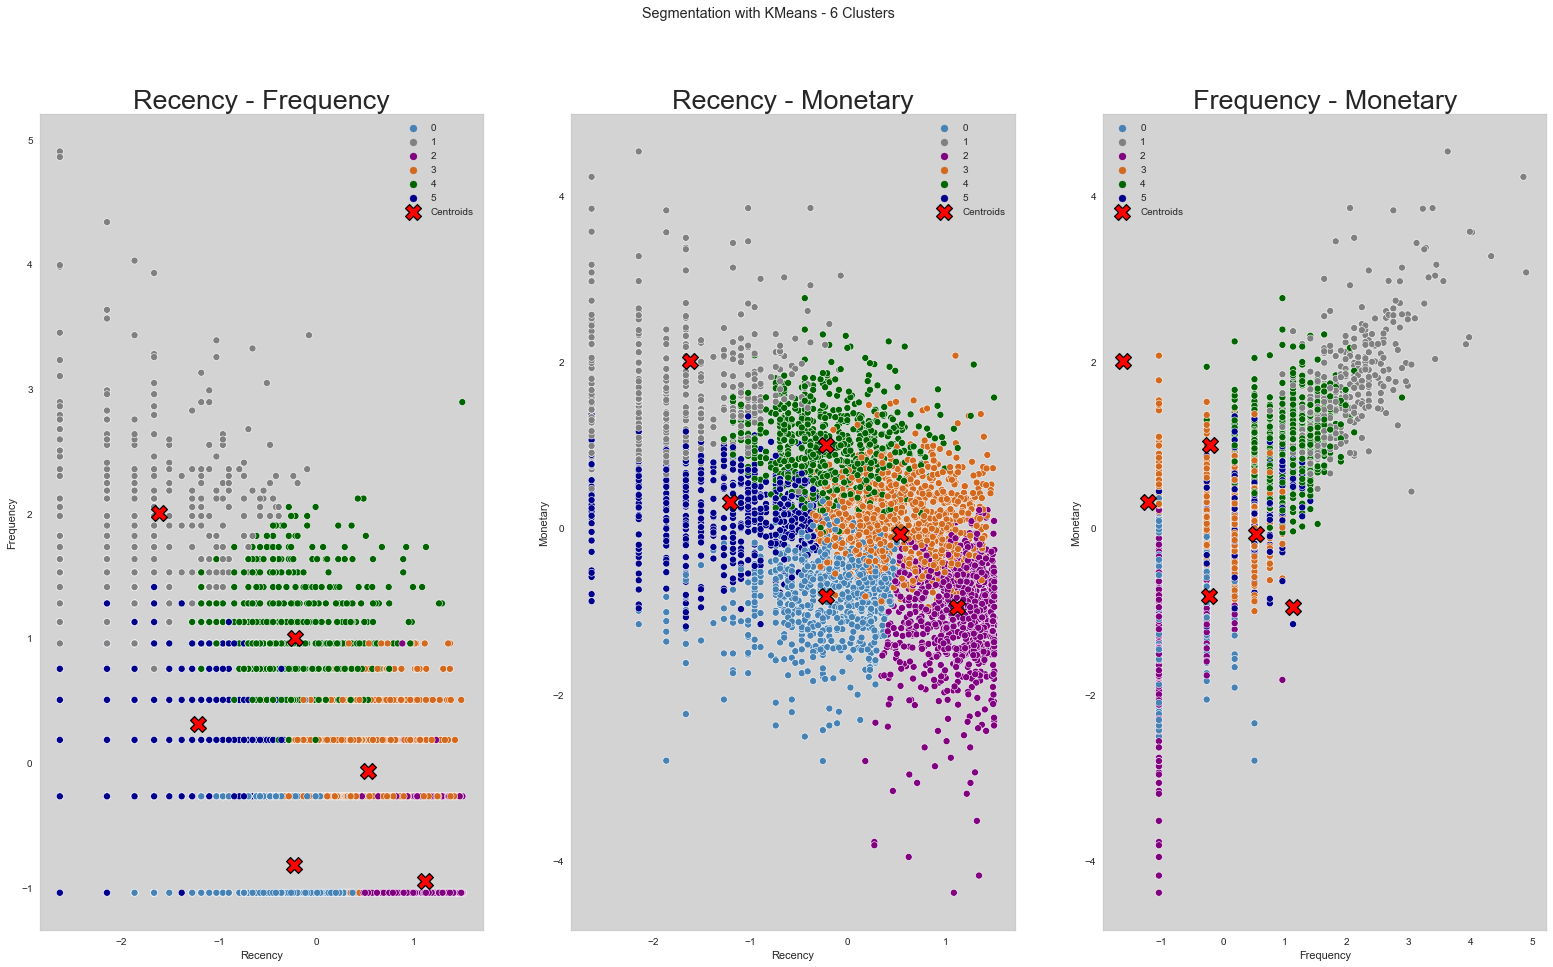

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(27, 15))

for i, feature in list(enumerate(combinations(["Recency", "Frequency", "Monetary"], 2))):

    sns.scatterplot(x = rfm_clustering[feature[0]],
                    y = rfm_clustering[feature[1]],
                    hue = cluster, 
                    palette = palette[: len(set(cluster))],
                    ax = axes[i]).set_title(feature[0] + " - " + feature[1], fontsize=27)

    sns.scatterplot(x = kmeans.cluster_centers_[:, 0],
                    y = kmeans.cluster_centers_[:, 1],
                    s = 250,
                    color = 'red',
                    label = 'Centroids',
                    marker = "X",
                    ax = axes[i],
                    edgecolor = "black")

plt.suptitle("Segmentation with KMeans - 6 Clusters")
for ax in axes:
    ax.set_facecolor("lightgrey")
    ax.grid(False)
    
plt.show()

### Box plot

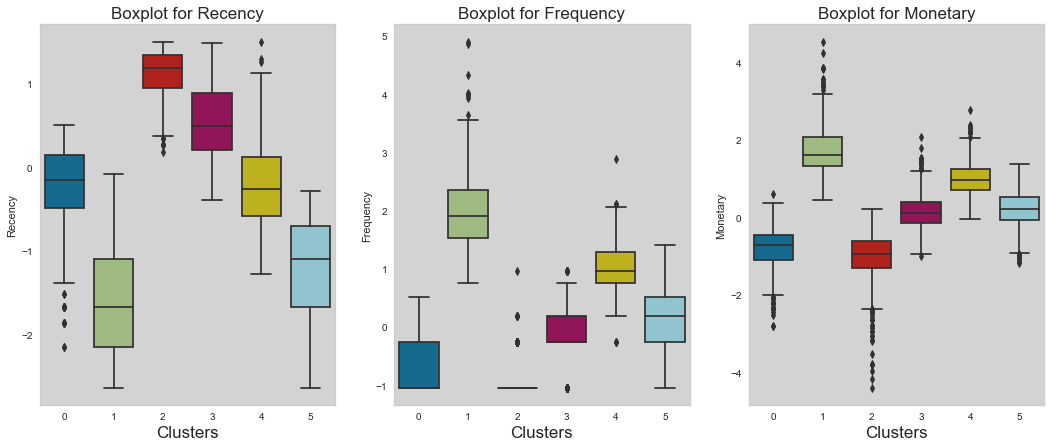

In [100]:
fig, axes = plt.subplots(1, 3, figsize = (18, 7))

for ax in axes:
    ax.set_facecolor("lightgrey")
    ax.set_xlabel("Clusters", fontsize=17)
    
sns.boxplot(x = cluster, y = "Recency", data = rfm_clustering, ax = axes[0]).set_title("Boxplot for Recency", fontsize=17)
sns.boxplot(x = cluster, y = "Frequency", data = rfm_clustering, ax = axes[1]).set_title("Boxplot for Frequency", fontsize=17)
sns.boxplot(x = cluster, y = "Monetary", data = rfm_clustering, ax = axes[2]).set_title("Boxplot for Monetary", fontsize=17)

plt.show()

In [101]:
plt.rcdefaults()
# plt.rcdefaults: 不想用之前修改的参数了，恢复到默认

## 5.  Forecasting with Prophet

In [102]:
df = pd.read_csv('Online_Retail_data.csv', index_col=0)

display(df.head())

print(df.shape)

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   white hanging heart t-light holder         6   
1     536365     71053                  white metal lantern         6   
2     536365    84406B       cream cupid hearts coat hanger         8   
3     536365    84029G  knitted union flag hot water bottle         6   
4     536365    84029E       red woolly hottie white heart.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  Total_Price  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom        15.30  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom        22.00  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom        20.34

(392735, 9)


## 5.1 Data Preparation for Time Series

- Use only UK sales for this analysis.

In [103]:
df = df[df['Country'] == 'United Kingdom']

In [104]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f'First observation of data is {df.InvoiceDate.min()}')
print(f'Last observation of data is {df.InvoiceDate.max()}')

print(f'We have {(df.InvoiceDate.max() - df.InvoiceDate.min()).days} days.')

First observation of data is 2010-12-01 08:26:00
Last observation of data is 2011-12-09 12:49:00
We have 373 days.


- Let's set 'InvoiceDate' as our index, which can help us to analyze weekly and daily data.

In [105]:
df.set_index('InvoiceDate',
             inplace=True)
df.tail()

InvoiceNo StockCode                          Description  \
InvoiceDate                                                                     
2011-12-09 12:31:00     581585     22466       fairy tale cottage night light   
2011-12-09 12:49:00     581586     22061  large cake stand  hanging strawbery   
2011-12-09 12:49:00     581586     23275     set of 3 hanging owls ollie beak   
2011-12-09 12:49:00     581586     21217        red retrospot round cake tins   
2011-12-09 12:49:00     581586     20685                doormat red retrospot   

                     Quantity  UnitPrice  CustomerID         Country  \
InvoiceDate                                                            
2011-12-09 12:31:00        12       1.95     15804.0  United Kingdom   
2011-12-09 12:49:00         8       2.95     13113.0  United Kingdom   
2011-12-09 12:49:00        24       1.25     13113.0  United Kingdom   
2011-12-09 12:49:00        24       8.95     13113.0  United Kingdom   
2011-12-09 12:49:00        10       7.08     13113.0  United Kingdom   

                     Total_Price  
InvoiceDate                       
2011-12-09 12:31:00         23.4  
2011-12-09 12:49:00         23.6  
2011-12-09 12:49:00         30.0  
2011-12-09 12:49:00        214.8  
2011-12-09 12:49:00         70.8

> **Weekly**

In [106]:
Total_Prices = pd.DataFrame(df.groupby('InvoiceDate')['Total_Price'].sum())

Total_Prices

Total_Price
InvoiceDate                     
2010-12-01 08:26:00       139.12
2010-12-01 08:28:00        22.20
2010-12-01 08:34:00       348.78
2010-12-01 08:35:00        17.85
2010-12-01 09:00:00       204.00
...                          ...
2011-12-09 12:21:00        29.88
2011-12-09 12:23:00       124.60
2011-12-09 12:25:00       140.64
2011-12-09 12:31:00       329.05
2011-12-09 12:49:00       339.20

[15261 rows x 1 columns]

In [107]:
weekly_prices = Total_Prices.resample('W').sum()

weekly_prices

Total_Price
InvoiceDate             
2010-12-05     118082.07
2010-12-12     145153.96
2010-12-19     127871.19
2010-12-26      27718.88
2011-01-02          0.00
2011-01-09      86324.26
2011-01-16      67023.92
2011-01-23      61877.01
2011-01-30      77993.36
2011-02-06      80055.91
2011-02-13      55289.95
2011-02-20      83164.03
2011-02-27      90477.88
2011-03-06      73046.94
2011-03-13      81906.51
2011-03-20      95252.33
2011-03-27      85985.98
2011-04-03      97643.88
2011-04-10      81441.70
2011-04-17     111093.25
2011-04-24      75191.26
2011-05-01      58688.72
2011-05-08      97553.92
2011-05-15     122572.40
2011-05-22     148554.85
2011-05-29      89536.64
2011-06-05      74779.61
2011-06-12      96438.26
2011-06-19      97787.32
2011-06-26      81796.88
2011-07-03      66540.75
2011-07-10      89001.47
2011-07-17      88696.63
2011-07-24     123141.07
2011-07-31      97209.49
2011-08-07     103066.78
2011-08-14      80256.80
2011-08-21      98723.66
2011-08-28     102969.19
2011-09-04      75947.40
2011-09-11     123156.30
2011-09-18     148250.14
2011-09-25     170300.65
2011-10-02     154974.61
2011-10-09     190814.91
2011-10-16     146736.79
2011-10-23     143097.74
2011-10-30     165954.93
2011-11-06     190685.82
2011-11-13     207773.63
2011-11-20     200098.90
2011-11-27     188868.22
2011-12-04     195007.49
2011-12-11     161947.46

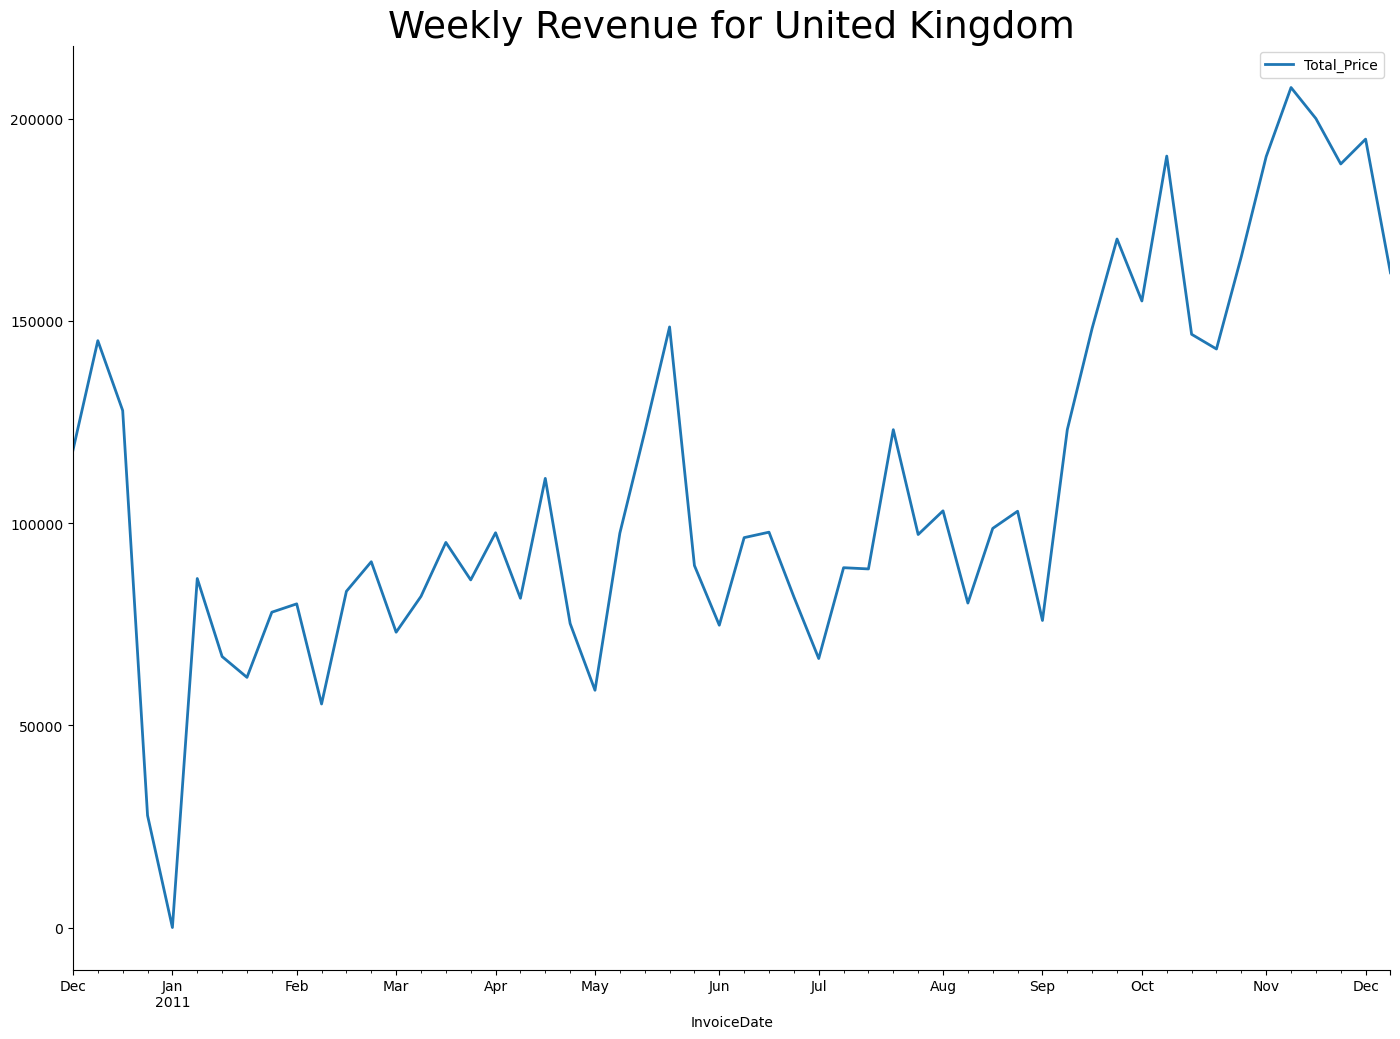

In [108]:
fig, ax = plt.subplots(figsize=(17,12))

weekly_prices.plot(ax=ax,
                   lw=2).set_title('Weekly Revenue for United Kingdom',fontsize=27)

ax.legend(loc='best')
sns.despine()
plt.show()

### Analysis: 

- From above figure, there is an overall upward trend. 

- 1. In earlier January, this retailer was closed. So revenue is 0.

- 2. The first peak is in the middle of May.

- 3. The second peak is in the beginning of October.

- 4. Then the revenue top out in the middle of November.

> **Daily Data**

- Let's convert data to daily form with using resample method. Let's dive in.

In [109]:
daily_prices = pd.DataFrame(df.groupby('InvoiceDate'
                                       ).sum().resample('D').sum()['Total_Price'])

daily_prices

Total_Price
InvoiceDate             
2010-12-01      34662.95
2010-12-02      40698.98
2010-12-03      17916.64
2010-12-04          0.00
2010-12-05      24803.50
...                  ...
2011-12-05      45548.33
2011-12-06      38424.19
2011-12-07      31102.15
2011-12-08      35813.81
2011-12-09      11058.98

[374 rows x 1 columns]

Let's find out 0 revenue.

In [110]:
daily_prices[daily_prices['Total_Price'] == 0.00]

Total_Price
InvoiceDate             
2010-12-04           0.0
2010-12-11           0.0
2010-12-18           0.0
2010-12-24           0.0
2010-12-25           0.0
...                  ...
2011-11-05           0.0
2011-11-12           0.0
2011-11-19           0.0
2011-11-26           0.0
2011-12-03           0.0

[69 rows x 1 columns]

In [111]:
daily_prices.reset_index(inplace=True)

daily_prices['Closed'] = np.where(daily_prices['Total_Price']==0,
                                  1, 0)

daily_prices.set_index('InvoiceDate',
                       inplace=True)

In [112]:
daily_prices['weekday'] = daily_prices.index.day_name()

daily_prices

Total_Price  Closed    weekday
InvoiceDate                                
2010-12-01      34662.95       0  Wednesday
2010-12-02      40698.98       0   Thursday
2010-12-03      17916.64       0     Friday
2010-12-04          0.00       1   Saturday
2010-12-05      24803.50       0     Sunday
...                  ...     ...        ...
2011-12-05      45548.33       0     Monday
2011-12-06      38424.19       0    Tuesday
2011-12-07      31102.15       0  Wednesday
2011-12-08      35813.81       0   Thursday
2011-12-09      11058.98       0     Friday

[374 rows x 3 columns]

In [113]:
daily_prices[daily_prices['Total_Price'] == 0]['weekday'].value_counts()

Saturday     53
Monday        6
Friday        4
Sunday        3
Tuesday       1
Wednesday     1
Thursday      1
Name: weekday, dtype: int64

- Based on above result, we don't have any record at 69 days. 53 of 69 is Saturday. This retailer could be closed on Saturdays. 



- Let's look at total revenues per weekday.

In [114]:
daily_prices.groupby('weekday')['Total_Price'].sum()

weekday
Friday        863095.82
Monday        951880.49
Saturday           0.00
Sunday        670059.45
Thursday     1267947.65
Tuesday      1049568.92
Wednesday    1100971.37
Name: Total_Price, dtype: float64

In [115]:
daily_prices_workdays = daily_prices[daily_prices['Total_Price'] > 0].copy()

daily_prices.drop('weekday',
                  axis=1,
                  inplace=True)

daily_prices_workdays.drop('weekday',
                           axis=1,
                           inplace=True)

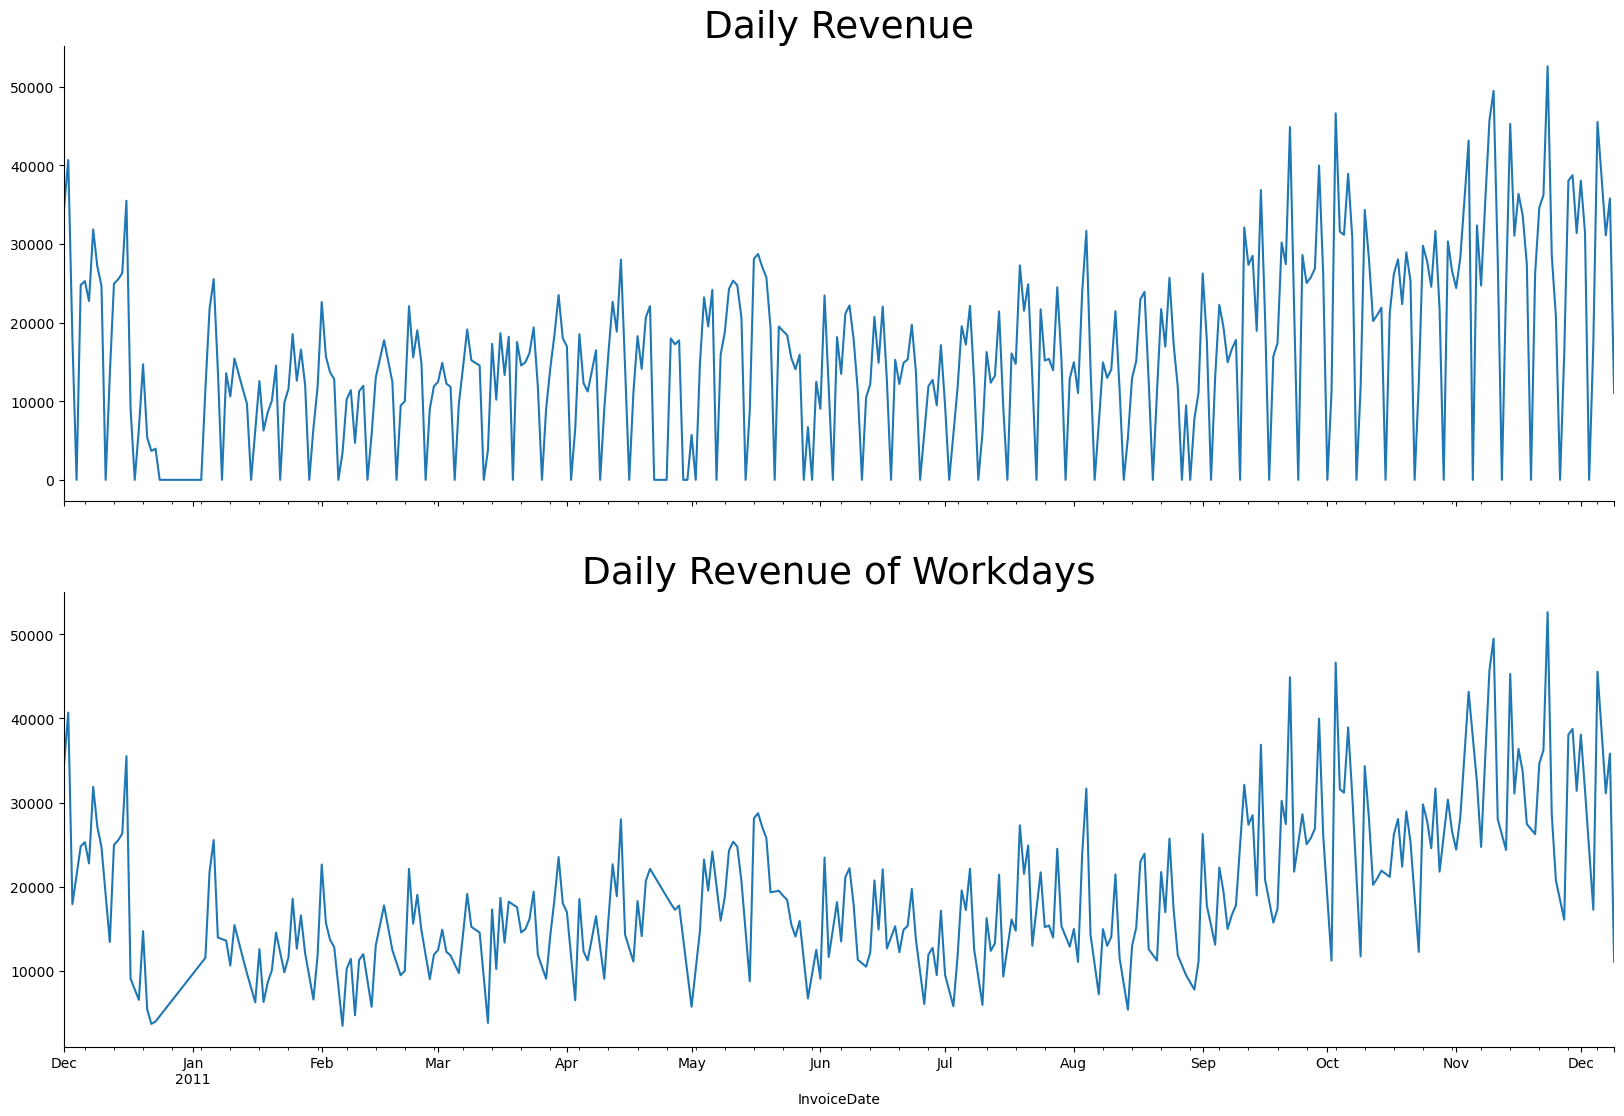

In [116]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,13))

daily_prices['Total_Price'].plot(ax=axes[0]).set_title('Daily Revenue', fontsize=27)

daily_prices_workdays['Total_Price'].plot(ax=axes[1]).set_title('Daily Revenue of Workdays', fontsize=27)

sns.despine()
plt.show()

## 5.2 Stationarity

- As we can see above daily revenue graphs, we have an increasing trend for end of the year.

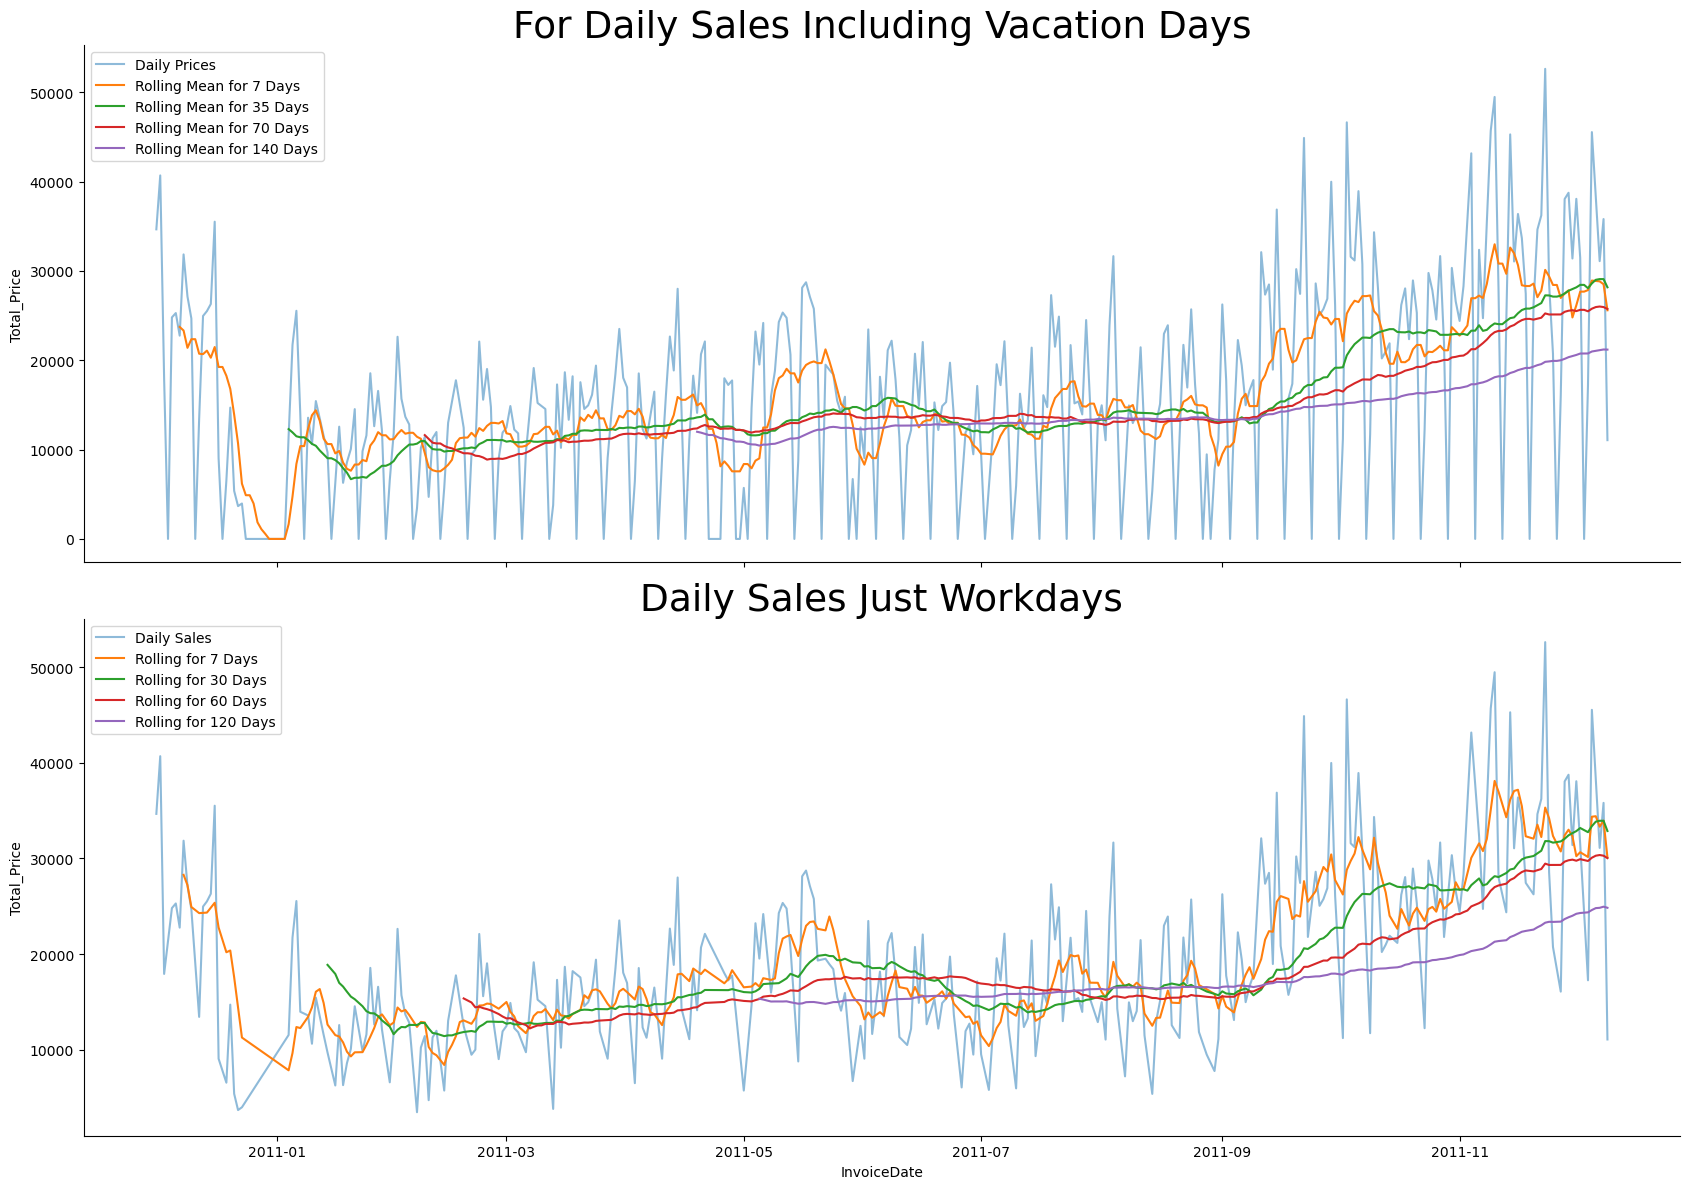

In [117]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(17,12))

sns.lineplot(x=daily_prices.index,
             y=daily_prices['Total_Price'],
             ax=axes[0],
             alpha=0.5,
             label='Daily Prices').set_title('For Daily Sales Including Vacation Days',
                                             fontsize=27)

sns.lineplot(x=daily_prices.index,
             y=daily_prices['Total_Price'].rolling(7).mean(),
             ax=axes[0],
             label='Rolling Mean for 7 Days')

sns.lineplot(x=daily_prices.index,
             y=daily_prices['Total_Price'].rolling(35).mean(),
             ax=axes[0],
             label='Rolling Mean for 35 Days')

sns.lineplot(x=daily_prices.index,
             y=daily_prices['Total_Price'].rolling(70).mean(),
             ax=axes[0],
             label='Rolling Mean for 70 Days')

sns.lineplot(x=daily_prices.index,
             y=daily_prices['Total_Price'].rolling(140).mean(),
             ax=axes[0],
             label='Rolling Mean for 140 Days')

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'],
             ax=axes[1],
             alpha=0.5,
             label='Daily Sales').set_title('Daily Sales Just Workdays',
                                            fontsize=27)

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'].rolling(7).mean(),
             ax=axes[1],
             label='Rolling for 7 Days')

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'].rolling(30).mean(),
             ax=axes[1],
             label='Rolling for 30 Days')

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'].rolling(60).mean(),
             ax=axes[1],
             label='Rolling for 60 Days')

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'].rolling(120).mean(),
             ax=axes[1],
             label='Rolling for 120 Days')

ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

- Let's check stationarity. Stationarity simply means that, our series has constant mean, variance on different times.

- In above rolling mean plots, we saw that our mean values increase over time.

- But, let's check it with Augmented Dickey Fuller test.

## Augmented Dickey-Fuller Test(ADF Test) 

In [118]:
def check_ADF(series, check = 0.05):
    
    ADF = adfuller(series, autolag='AIC')
    
    print(f"H0:{series.name} is non-stationary.")
    print(f"H1:{series.name} is stationary. \n")
    
    test_statistic = ADF[0]
    print(f"ADF test statistic: {ADF[0]}")
    
    p_value = ADF[1]
    print(f"P-value: {ADF[1]}")
    
    print(f"Number of lags: {ADF[2]}")
    print('\nCritical Values: \n')
    for k, item in ADF[4].items():
        print('\t',key,'\t',item)
        
    print(f"\nFor {check} significan level: \n")
    if p_value < check:
        print('We can reject null hypothesis. This series is stationary.')
    else:
        print('We cannot reject null hypothesis. This series is non-stationary.')

In [119]:
print('Performing Augmented Dickey-Fuller test for Total price \n')

check_ADF(daily_prices['Total_Price'])

print('\nPerforming Augmented Dickey-Fuller test for Total Price (for workdays)\n')

check_ADF(daily_prices_workdays['Total_Price'])

Performing Augmented Dickey-Fuller test for Total price 

H0:Total_Price is non-stationary.
H1:Total_Price is stationary. 

ADF test statistic: -2.371442041572212
P-value: 0.14995941633236815
Number of lags: 16

Critical Values: 

	 Need Attention 	 -3.44880082033912
	 Need Attention 	 -2.869670179576637
	 Need Attention 	 -2.5711012838861036

For 0.05 significan level: 

We cannot reject null hypothesis. This series is non-stationary.

Performing Augmented Dickey-Fuller test for Total Price (for workdays)

H0:Total_Price is non-stationary.
H1:Total_Price is stationary. 

ADF test statistic: -1.6611112579837573
P-value: 0.45125221489784734
Number of lags: 13

Critical Values: 

	 Need Attention 	 -3.4530232710482367
	 Need Attention 	 -2.871523926671883
	 Need Attention 	 -2.5720897694878424

For 0.05 significan level: 

We cannot reject null hypothesis. This series is non-stationary.


- For ADF test, this series is not stationary. To make it stationary, we have two main option.

    - 1- Take difference until it become stationary.

    - 2- Apply transformations: Log, square root, etc.
    
    

> We can take difference with using .diff() method.


> In this problem, our series has seasonal behaivor. Our revenue is increasing from saturday to thursday, then it decrease. For taking difference of seasonal series, we need set period in diff method.

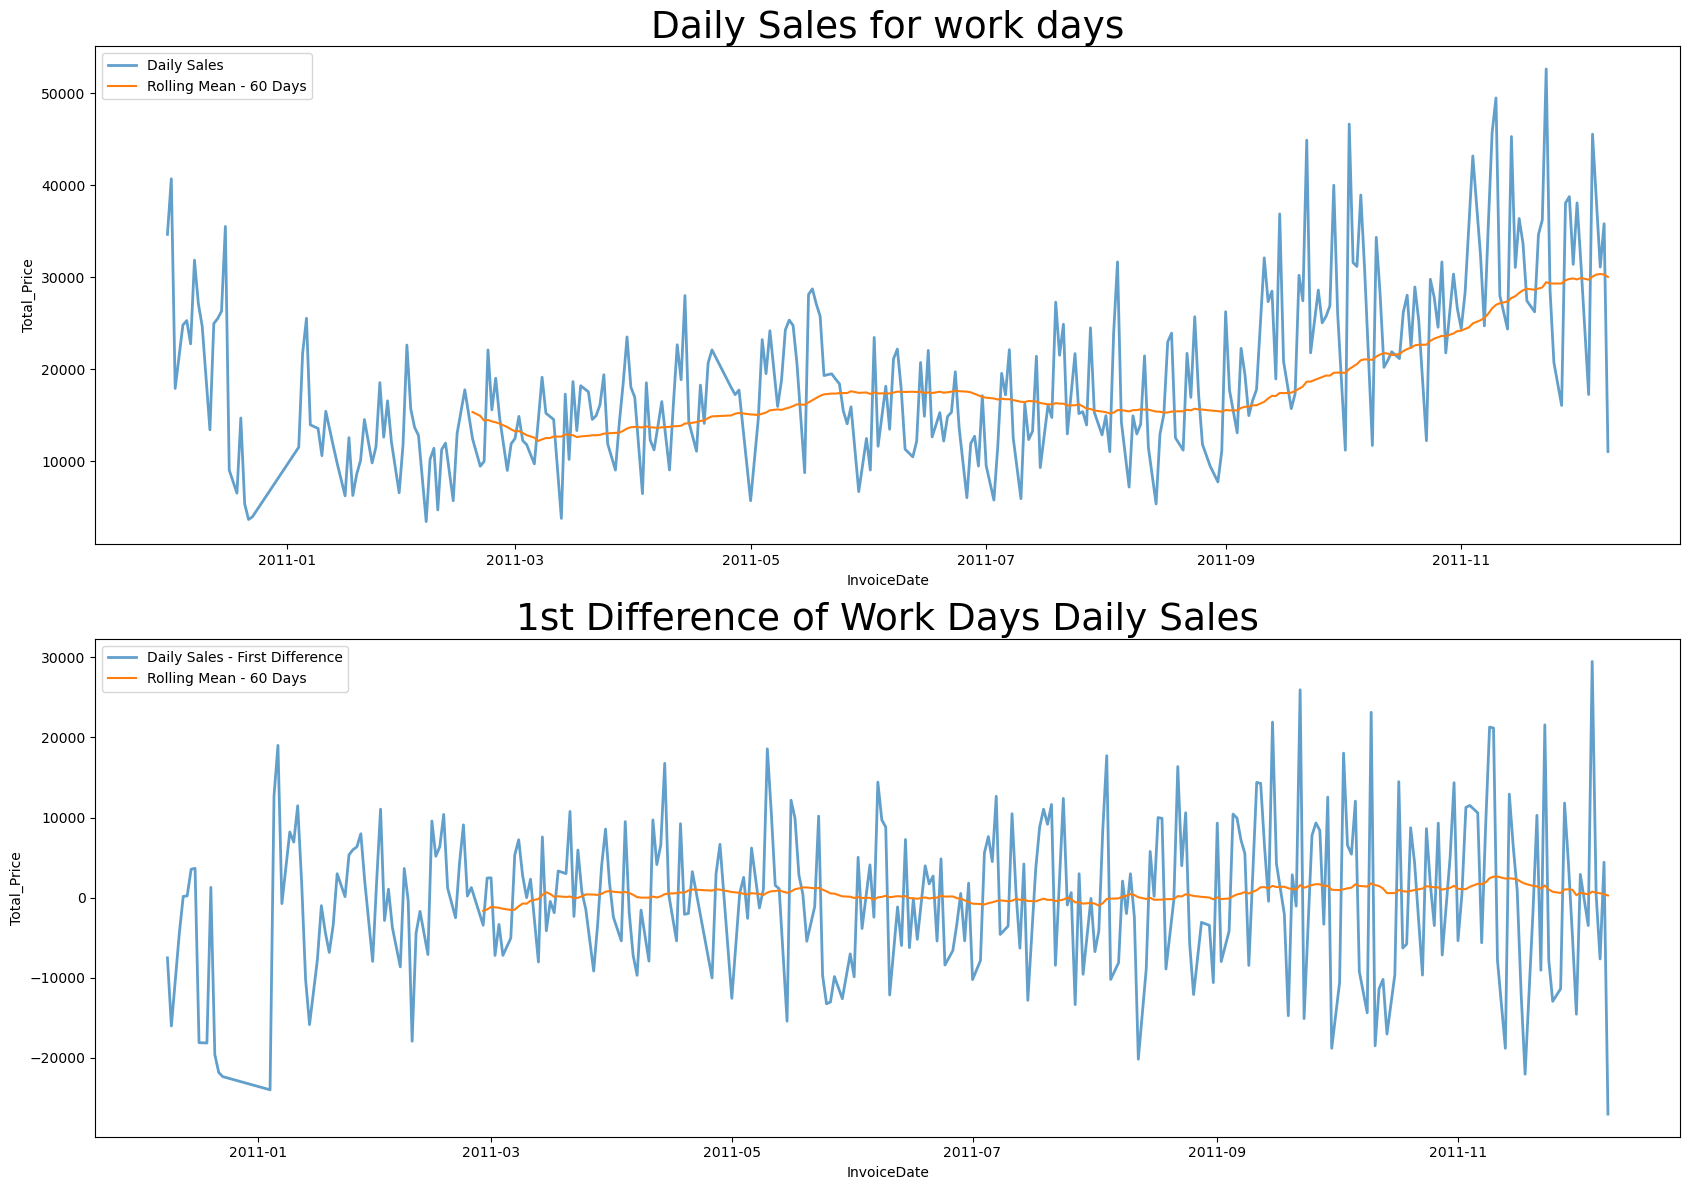

In [120]:
fig, axes = plt.subplots(2, 1, figsize=(17,12))

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'],
             ax=axes[0],
             label='Daily Sales',
             alpha=0.7,
             lw=2).set_title('Daily Sales for work days',
                             fontsize=27)

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'].rolling(60).mean(),
             ax=axes[0],
             label='Rolling Mean - 60 Days')

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'].diff(7),
             ax=axes[1],
             label='Daily Sales - First Difference',
             alpha=0.7,
             lw=2).set_title('1st Difference of Work Days Daily Sales',
                             fontsize=27)

sns.lineplot(x=daily_prices_workdays.index,
             y=daily_prices_workdays['Total_Price'].diff(7).rolling(60).mean(),
             ax=axes[1],
             label='Rolling Mean - 60 Days')

plt.legend()
plt.tight_layout()
plt.show()

- Nice, we have a constant mean over time. Let's look at ADF test results of 1st differenced series.

In [121]:
print('Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)')

check_ADF(daily_prices['Total_Price'].diff(7).dropna())

print('\nPerforming Augmented Dickey-Fuller test for 1st Difference of Work Days Sales')

check_ADF(daily_prices_workdays['Total_Price'].diff(6).dropna())

Performing Augmented Dickey-Fuller test for 1st Difference Revenue (All Days)
H0:Total_Price is non-stationary.
H1:Total_Price is stationary. 

ADF test statistic: -7.211241124675084
P-value: 2.2319745316403305e-10
Number of lags: 13

Critical Values: 

	 Need Attention 	 -3.4490114443793214
	 Need Attention 	 -2.8697627072503757
	 Need Attention 	 -2.5711506161673716

For 0.05 significan level: 

We can reject null hypothesis. This series is stationary.

Performing Augmented Dickey-Fuller test for 1st Difference of Work Days Sales
H0:Total_Price is non-stationary.
H1:Total_Price is stationary. 

ADF test statistic: -6.345126133126619
P-value: 2.694674744994089e-08
Number of lags: 11

Critical Values: 

	 Need Attention 	 -3.453342167806272
	 Need Attention 	 -2.871663828287282
	 Need Attention 	 -2.572164381381345

For 0.05 significan level: 

We can reject null hypothesis. This series is stationary.


- Now We make the series stationary. Let's decompose and examine its components.




## 5.3 Seasonality, Decomposition

In [122]:
decompose = seasonal_decompose(daily_prices['Total_Price'],
                               period=7)

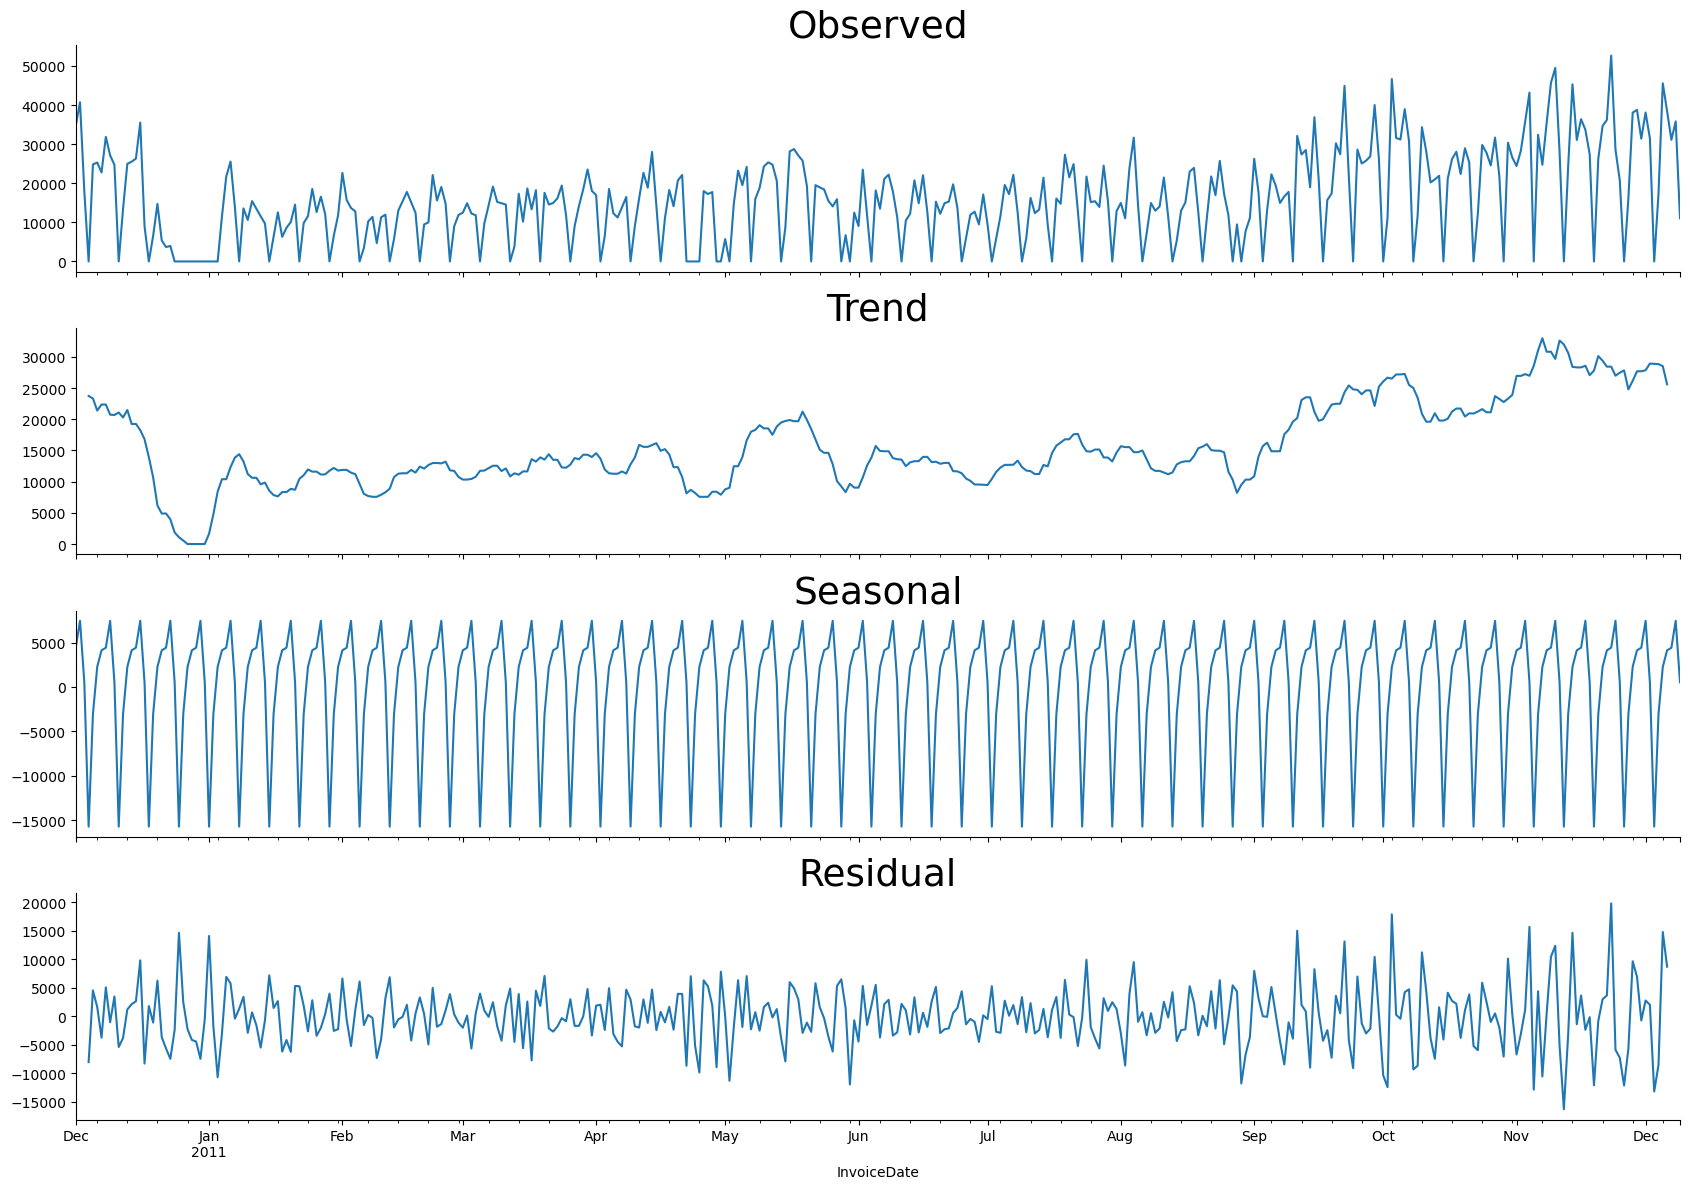

In [123]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(17,12))

decompose.observed.plot(ax=axes[0]).set_title('Observed',fontsize=27)

decompose.trend.plot(ax=axes[1]).set_title('Trend',fontsize=27)

decompose.seasonal.plot(ax=axes[2]).set_title('Seasonal',fontsize=27)

decompose.resid.plot(ax=axes[3]).set_title('Residual',fontsize=27)

sns.despine()
plt.tight_layout()
plt.show()

- We can saw trend, seasonal component and residual. We know we have weekly seasonality.

> We need normal distributed residual. Let's look at it.

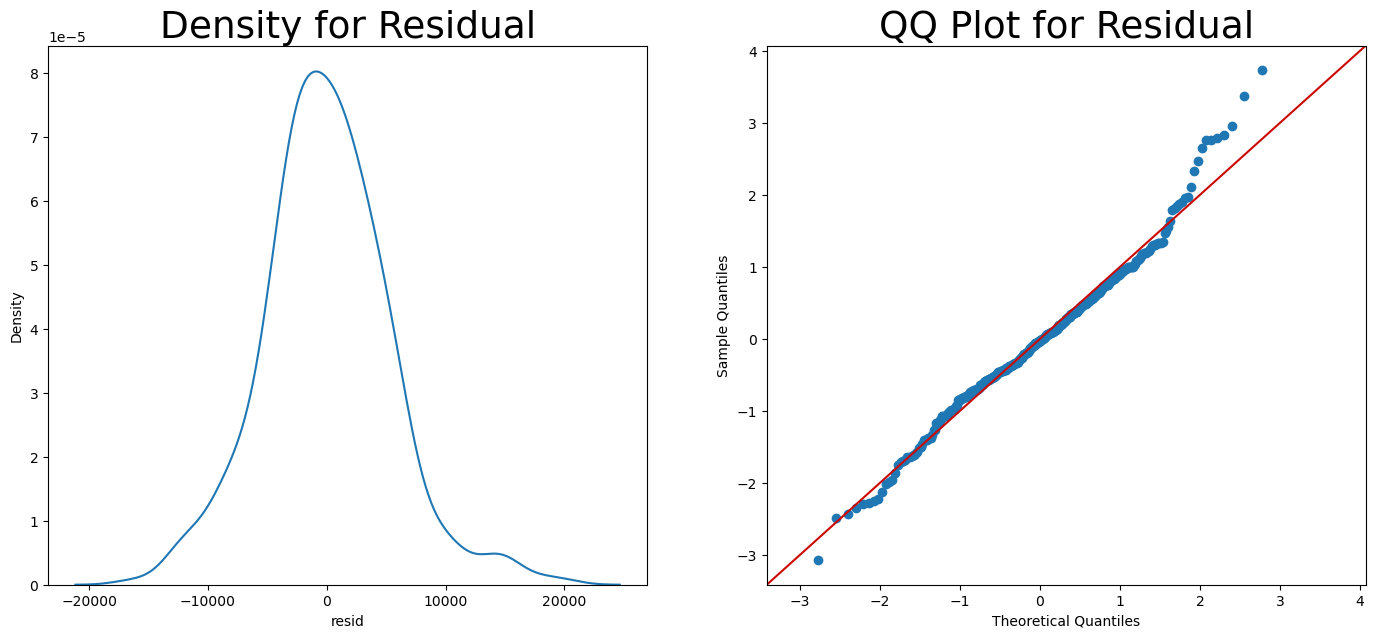

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(17,7))

sns.kdeplot(decompose.resid,
            ax=axes[0]).set_title('Density for Residual', fontsize=27)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    sm.qqplot(decompose.resid.dropna(),
              ax=axes[1],
              marker='o',
              line='45',
              fit=True)
    axes[1].set_title('QQ Plot for Residual',fontsize=27)
    

plt.show()

- As we can see kde plot and QQ plot, residual has normal distribution.

D:\A\envs\py37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


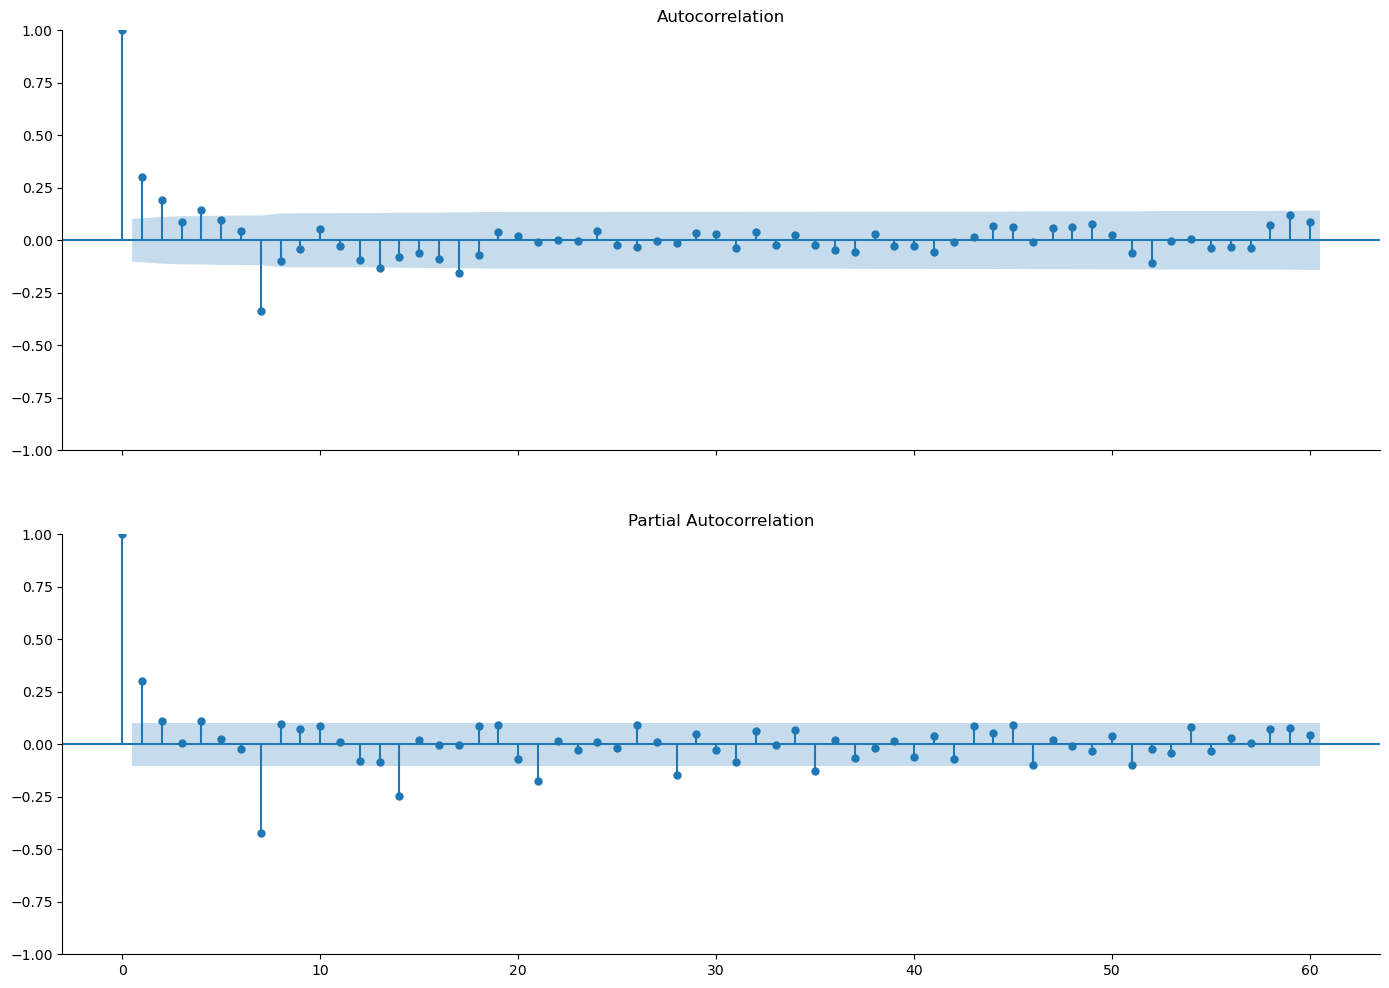

In [125]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig, axes = plt.subplots(2, 1, sharex=True, figsize=(17,12))

plot_acf(daily_prices['Total_Price'].diff(7).dropna(),
         lags=60,
         ax=axes[0])

plot_pacf(daily_prices['Total_Price'].diff(7).dropna(),
          lags=60,
          ax=axes[1])

sns.despine()
plt.show()

# 5.4 Modelling

- I will use daily sales data for model training. We have 0 values on saturdays, it is fixed. We can get rid of these records with subsetting the data, just like stock prices.

> For training set, I just get first 85% records of all days, and remaining part is validation set.

In [126]:
daily_data = daily_prices[['Total_Price']].dropna().reset_index()

daily_data.columns = ['ds','y']

train_size = int(0.85*len(daily_data))

train = daily_data.iloc[:train_size]

validation = pd.DataFrame(daily_data.iloc[train_size:])

print(f"Training Days:\t\t{len(train)} \nValidation Days:\t{len(validation)}")

Training Days:		317 
Validation Days:	57


- For this problem our metrics are R2, mean squared error and correlation. Actually, I don't like to use infinite intervaled metrics like MSE, but I just add it for variety.

In [127]:
def scores(y_true, y_pred):
    print(f"R2: {r2_score(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"Correlation: {np.corrcoef(y_true, y_pred)[0][1]}")

### Simple Model

In [128]:
from fbprophet import Prophet
import quandl
import pytrends

warnings.filterwarnings('ignore')

In [129]:
model = Prophet()

model.fit(train)

validation_pred = model.predict(validation)
train_pred = model.predict(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
print("For Training set: \n")
scores(train.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(validation.y, validation_pred.yhat)

For Training set: 

R2: 0.5358605876965918
MSE: 42957521.22013507
Correlation: 0.7322095676328957

For Validation set: 

R2: 0.47946930428158663
MSE: 93944135.48824283
Correlation: 0.840356924339991


- First model is simple prophet model with default parameters.

- We have 53% R2 for training and 48% R2 for validation set.

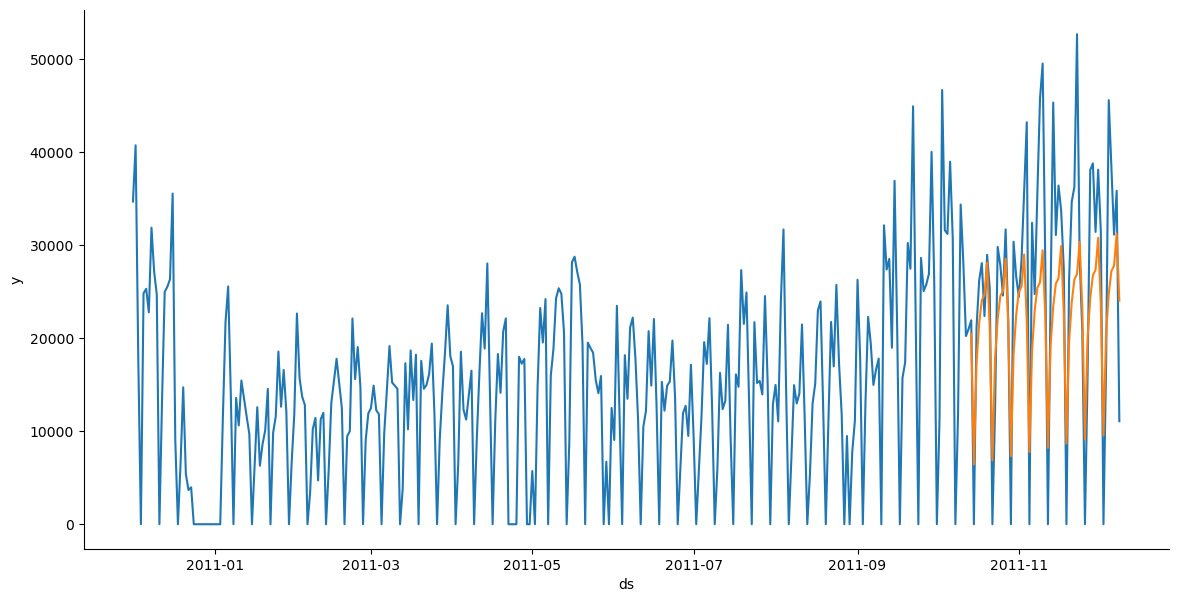

In [131]:
fig, axes = plt.subplots(figsize=(14,7))

sns.lineplot(x=daily_data.ds,
             y=daily_data.y,
             ax=axes)

sns.lineplot(x=validation_pred.ds,
             y=validation_pred.yhat,
             ax=axes)

sns.despine()
plt.show()

- It seems, the model does not capture huge peaks.


> Let's add some parameters.


### Prophet's parameters

- We can add holidays to prophet model with below format.

- I just add "Black Friday" as a holiday for three years.

In [132]:
black_friday = pd.DataFrame({'holiday':'black friday',
                             'ds':pd.to_datetime(['2011-11-24',
                                                  '2012-11-23',
                                                  '2013-11-22']),
                             'lower_window':0,
                             'upper_window':1})

- Saturdays doesn't have any sale record. Let's simply add "is_saturday" column as an extra regressor.

In [133]:
def is_saturday(ds):
    date = pd.to_datetime(ds)
    return date.day_name() == "Saturday"

daily_data["is_saturday"] = daily_data["ds"].apply(is_saturday)

train_new = daily_data.iloc[:train_size]
val_new = pd.DataFrame(daily_data.iloc[train_size:])

> **Prophet Function**

- holidays: use this for adding special days to model

- seasonality: If the data has seasonality, we can set daily_seasonality, weekly_seasonality, and yearly_seasonality parameters to True.

- _prior_scale: This parameter controls the flexibility of components' affects.

> Also we can use add_country_holidays(country) method for adding all holidays for a country.

In [134]:
model = Prophet(holidays = black_friday,
                daily_seasonality = True, 
                weekly_seasonality = True,
                holidays_prior_scale = 1,
                seasonality_prior_scale = 5,
                changepoint_prior_scale = 1)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(train_new)

val_pred = model.predict(val_new)
train_pred = model.predict(train_new)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [135]:
print("For Training set: \n")
scores(train_new.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val_new.y, val_pred.yhat)

For Training set: 

R2: 0.7243815018651745
MSE: 25509334.412111476
Correlation: 0.8512077881808444

For Validation set: 

R2: 0.47909211154463127
MSE: 94012210.33162321
Correlation: 0.8199230175031972


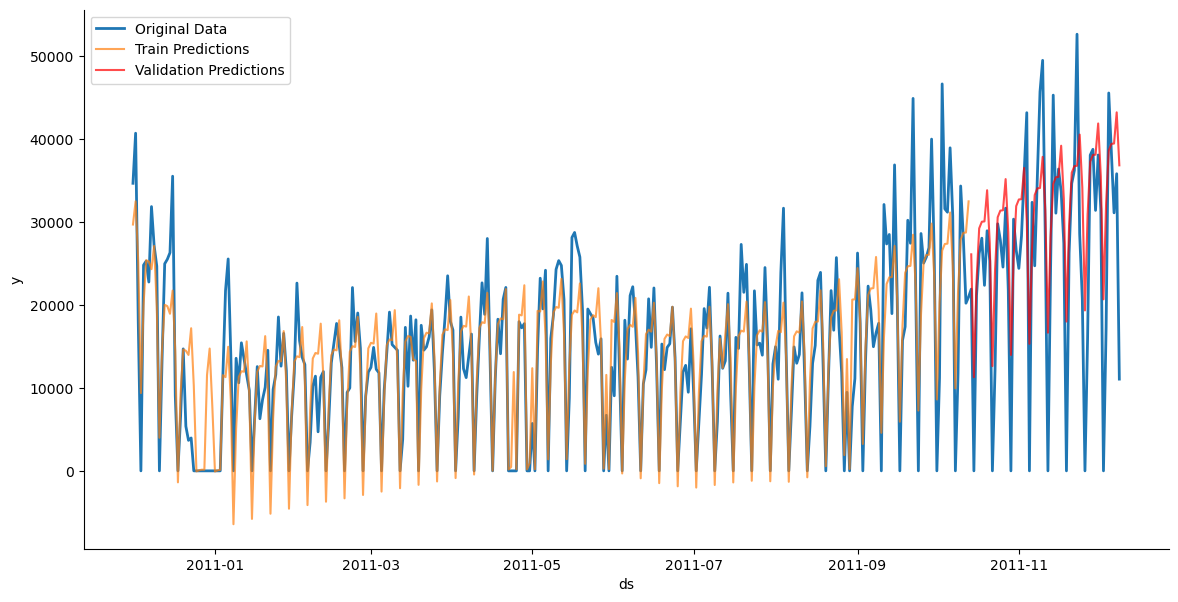

In [136]:
fig, axes = plt.subplots(figsize=(14,7))

sns.lineplot(x=daily_data.ds,
             y=daily_data.y,
             ax=axes,
             lw=2,
             label='Original Data')

sns.lineplot(x=train_pred.ds,
             y=train_pred.yhat,
             alpha=0.7,
             ax=axes,
             label='Train Predictions')

sns.lineplot(x=val_pred.ds,
             y=val_pred.yhat,
             alpha=0.7,
             ax=axes,
             color='red',
             label='Validation Predictions')

ax.legend(loc=1)
sns.despine()
plt.show()

- Look, we have a new problem: get negative valued forecasts.

- To get rid of this, Let's manually set them zero.

In [137]:
train_pred["yhat"] = np.where((train_pred.is_saturday == 0), train_pred.yhat, 0)
val_pred["yhat"] = np.where((val_pred.is_saturday == 0), val_pred.yhat, 0)

print("For Training set: \n")
scores(train_new.y, train_pred.yhat)

print("\nFor Validation set: \n")
scores(val_new.y, val_pred.yhat)

For Training set: 

R2: 0.7454343179007075
MSE: 23560831.941481337
Correlation: 0.8642582019413445

For Validation set: 

R2: 0.6851108298232618
MSE: 56830444.60238044
Correlation: 0.8512744391164463


- After optimizing some parameters, the R2 of the model for both training and validation is obviously increasing, to 75% and 69% respectively.

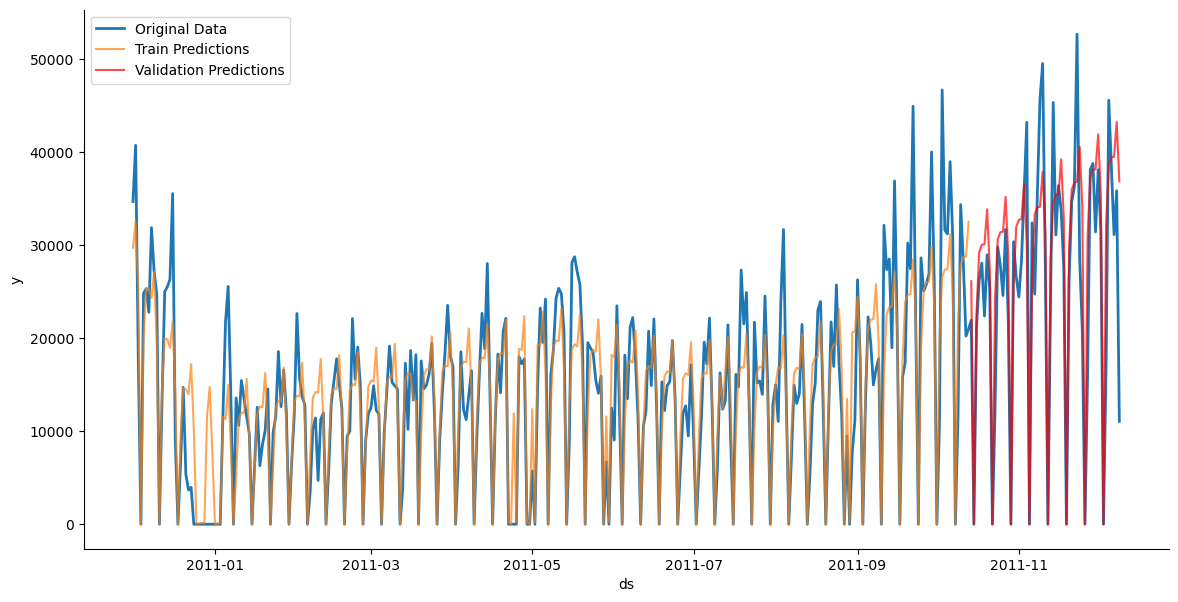

In [138]:
fig, axes = plt.subplots(figsize=(14,7))

sns.lineplot(x=daily_data.ds,
             y=daily_data.y,
             ax=axes,
             lw=2,
             label='Original Data')

sns.lineplot(x=train_pred.ds,
             y=train_pred.yhat,
             alpha=0.7,
             ax=axes,
             label='Train Predictions')

sns.lineplot(x=val_pred.ds,
             y=val_pred.yhat,
             alpha=0.7,
             ax=axes,
             color='red',
             label='Validation Predictions')

ax.legend(loc=1)
sns.despine()
plt.show()

### Forecasting Future

> Now, Let's build a new model for forecasting next year. I just add yearly seasonality to last model that we used.

In [139]:
model = Prophet(holidays = black_friday,
                daily_seasonality = True, 
                weekly_seasonality = True,
                yearly_seasonality = True,
                holidays_prior_scale = 1,
                seasonality_prior_scale = 5,
                changepoint_prior_scale = 1)

model.add_country_holidays(country_name = "UK")

model.add_regressor("is_saturday")

model.fit(daily_data)

In [140]:
future = model.make_future_dataframe(periods = 365)

future["is_saturday"] = future["ds"].apply(is_saturday)

future.tail()

ds  is_saturday
734 2012-12-04        False
735 2012-12-05        False
736 2012-12-06        False
737 2012-12-07        False
738 2012-12-08         True

In [141]:
forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

ds          yhat    yhat_lower    yhat_upper
734 2012-12-04  33231.124873  25336.989671  39939.024502
735 2012-12-05  32783.595301  25559.074680  40254.970050
736 2012-12-06  35385.363938  28126.586398  42686.183677
737 2012-12-07  27512.524864  20318.974261  34734.080290
738 2012-12-08   9613.355909   2234.148349  17295.503304

In [142]:
forecast['yhat'] = np.where((forecast['is_saturday']==0),
                            forecast.yhat, 0)

forecast['yhat_lower'] = np.where((forecast['is_saturday']==0),
                                  forecast.yhat_lower, 0)

forecast['yhat_upper'] = np.where((forecast['is_saturday']==0),
                                  forecast.yhat_upper, 0)

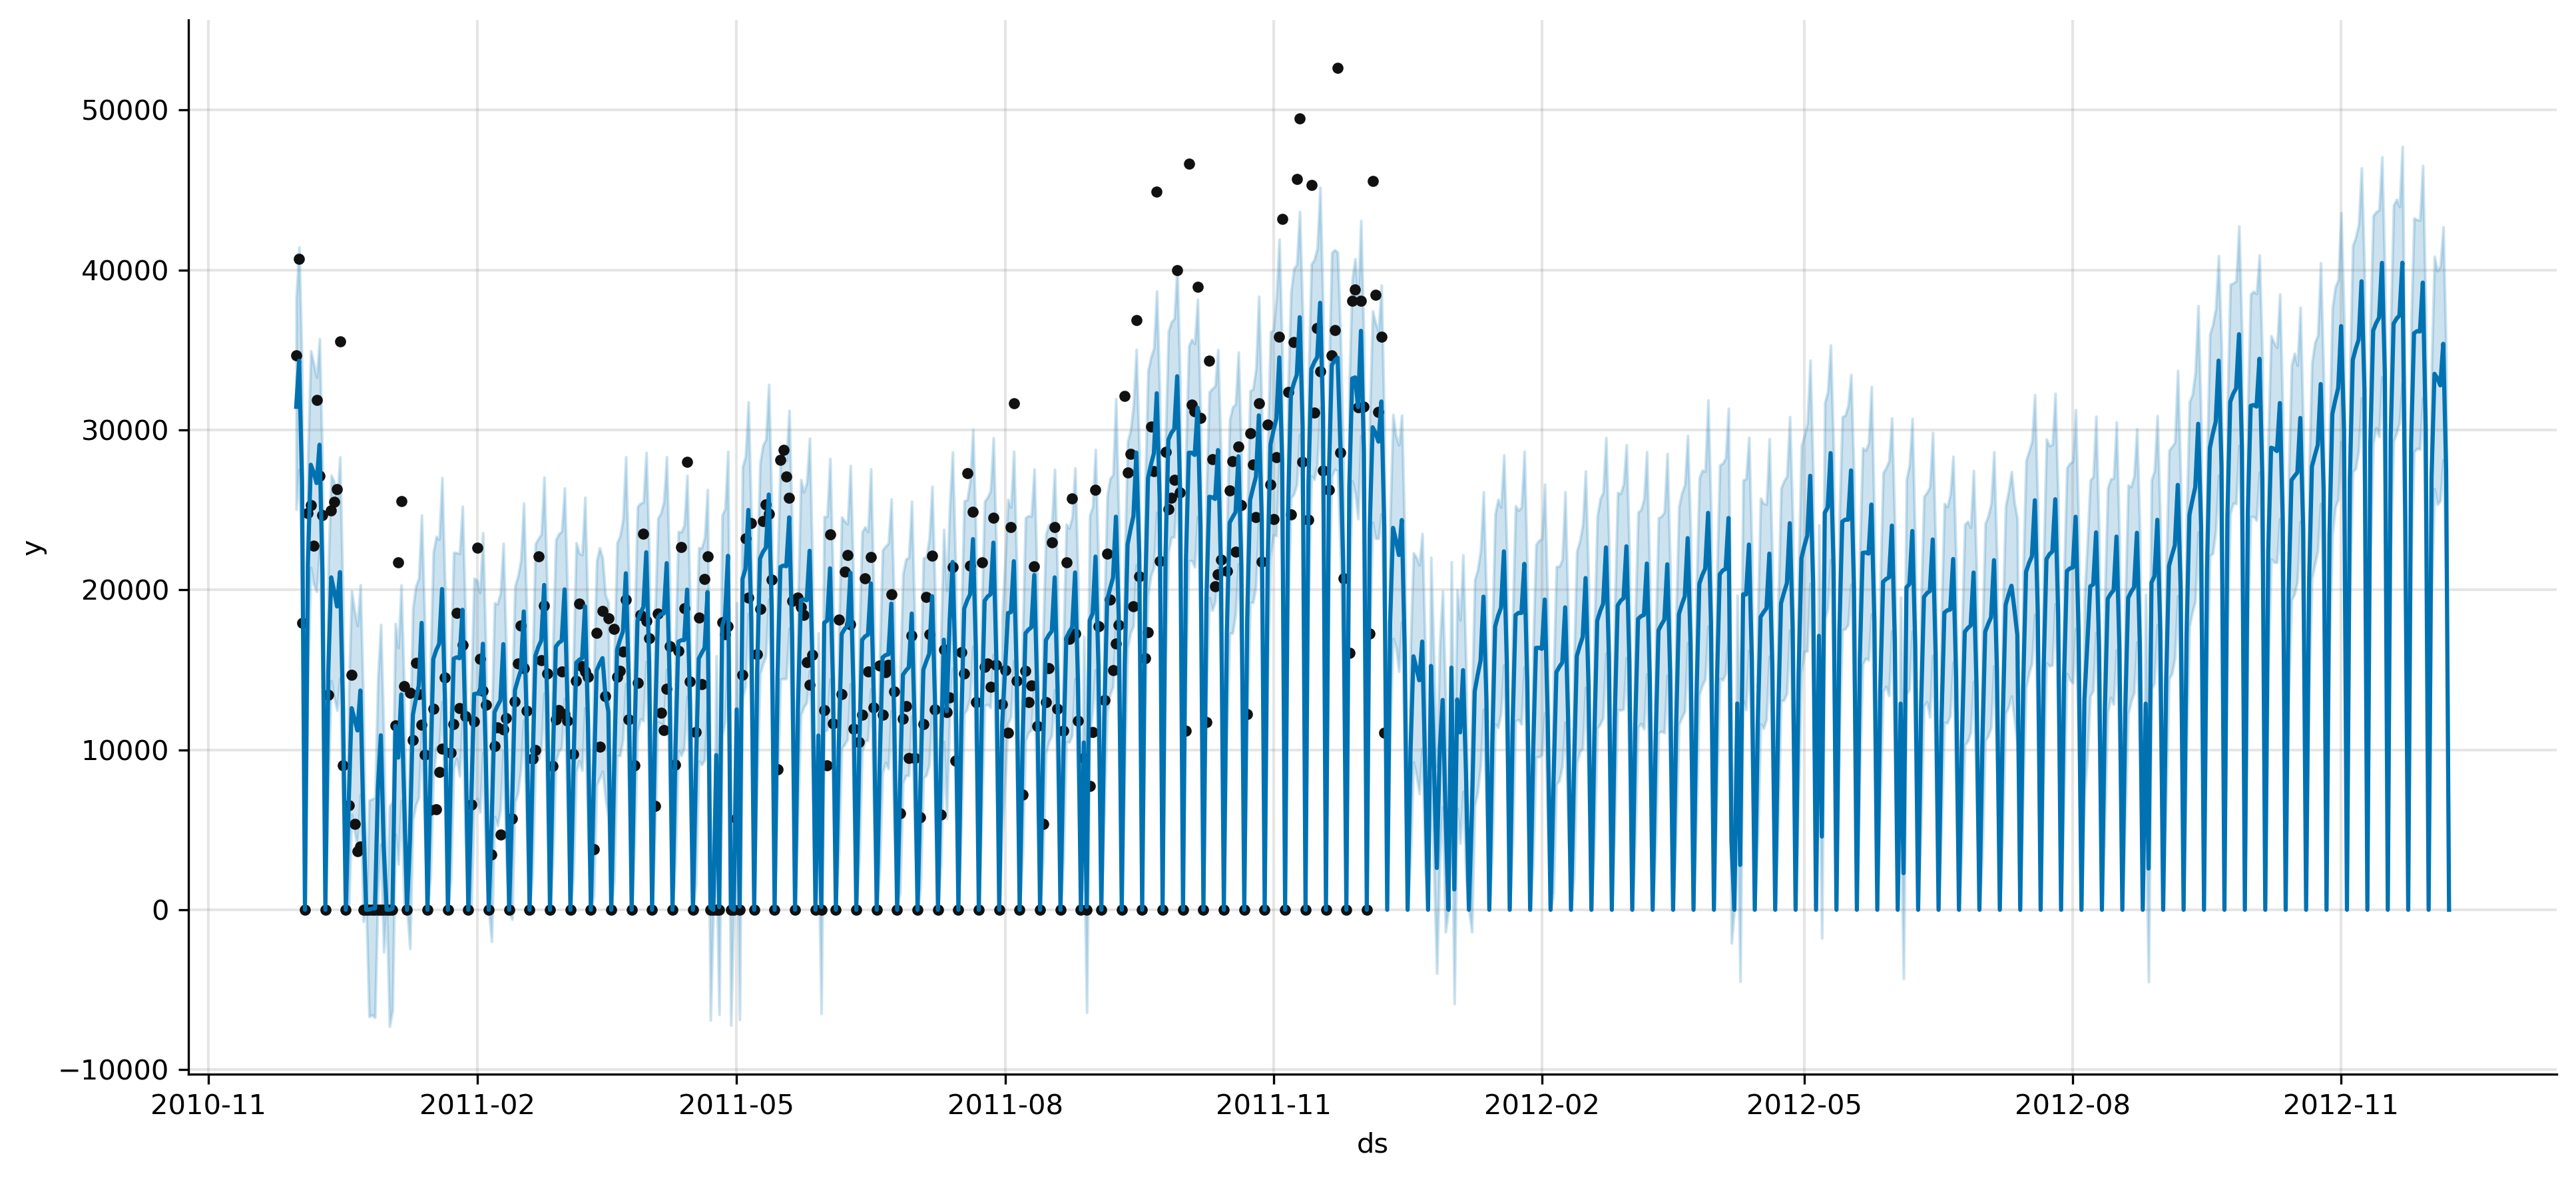

In [143]:
fig, axes = plt.subplots(figsize=(13,6),
                         dpi=300)

model.plot(forecast, ax=axes)

ax.set_title('Daily Revenue Forecast', fontsize=27)
ax.set_ylim(0, 80000)

sns.despine()
plt.show()

- Here is the results of this year's predictions and next year's forecast. Black dots represent actual revenue, and blue lines represent forecasts.

- In the last months of the year, our predictions on the border of upper confidence interval, or sometimes outside of it.

- If we look at next year's forecast, we can see minor peaks in the middle of the year, and also we have positive trend late of the year.